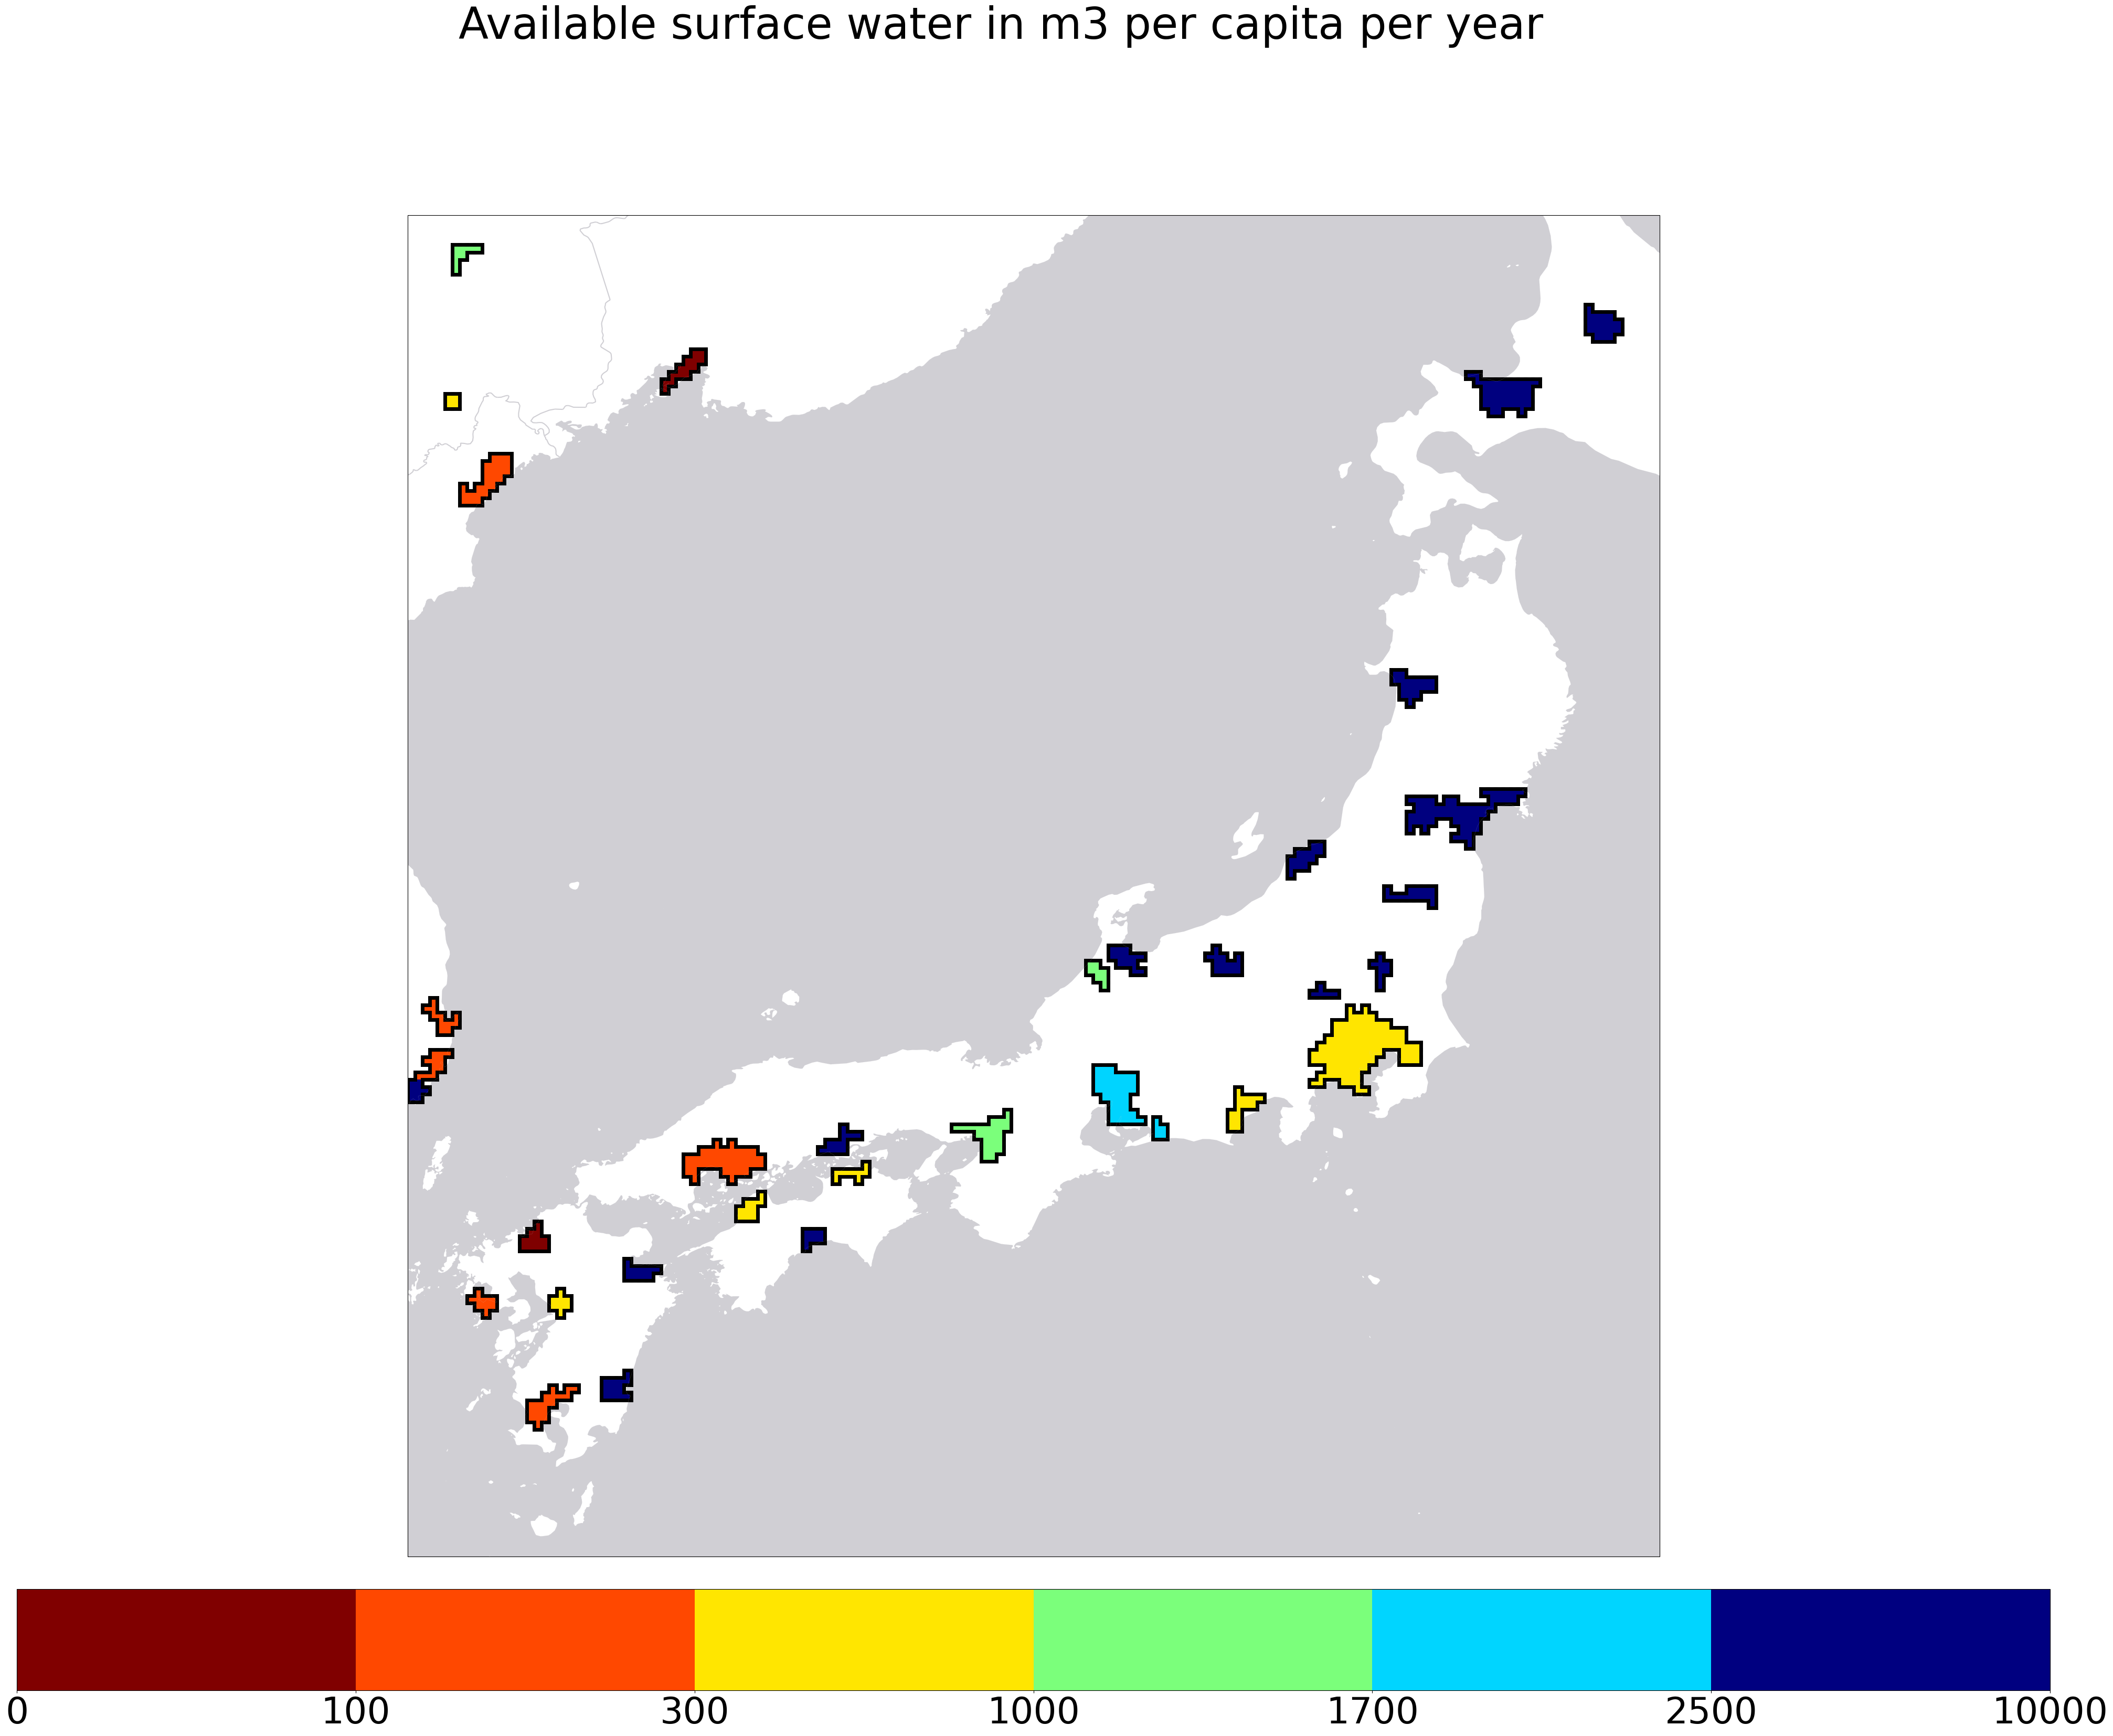

In [2]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import numpy as np

def geography(left, right, bottom, top):
    #
    resolution = 12
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent
    
#---------------------------------------------------------------------------------------------------------------
#  city maskの枠だけを表示
#---------------------------------------------------------------------------------------------------------------
def draw_mask_sotowaku(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=3):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    """
    mask_cropped = mask_cropped.filled(0)

    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] != 0:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right

    return ax
    
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(129, 143, 30, 45)

# wsi/pre/population_m3year.ipynb
population_path = f'{h08dir}/wsi/dat/population/population_threshold_world.npy'
population = np.load(population_path)
population_cropped = population[upperindex:lowerindex, leftindex:rightindex]

# wsi/pre/availability_m3year.ipynb
availability_path = f'{h08dir}/wsi/dat/availablewater/availablewater_threshold_world.npy'
availability = np.load(availability_path)
availability_cropped = availability[upperindex:lowerindex, leftindex:rightindex]

# wsi/pre/MPCY_citylonlat_citygrid.ipynb
grid_path = f'{h08dir}/wsi/dat/cmy/world_citygrid.npy'
citygrid = np.load(grid_path)
citygrid_masked = np.ma.masked_where(citygrid==0, citygrid)

region = citygrid_masked[upperindex:lowerindex, leftindex:rightindex]
region_masked = np.ma.masked_where(region==0, region)


threshold = 1e6
bounds = [0, 100, 300, 1000, 1700, 2500, 10000]

cmap = plt.get_cmap('jet_r', len(bounds))  # 10個の離散値
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.rcParams["font.size"] = 50
projection = ccrs.PlateCarree(central_longitude=0)
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(50,40), subplot_kw={'projection': projection})
imd = ax.imshow(region_masked, 
              cmap= cmap,
              norm = norm,
              extent=img_extent,
              transform=ccrs.PlateCarree(), 
             )
ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#ffffff')
ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#d0cfd4')
ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4')
ax.gridlines(visible=False)
cbar = fig.colorbar(imd, ax=ax, orientation='horizontal', pad=0.02)
fig.suptitle('Available surface water in m3 per capita per year')

draw_mask_sotowaku(img_extent, region_masked, ax=ax, sotowaku_color='black', linewidth=5)
plt.show()

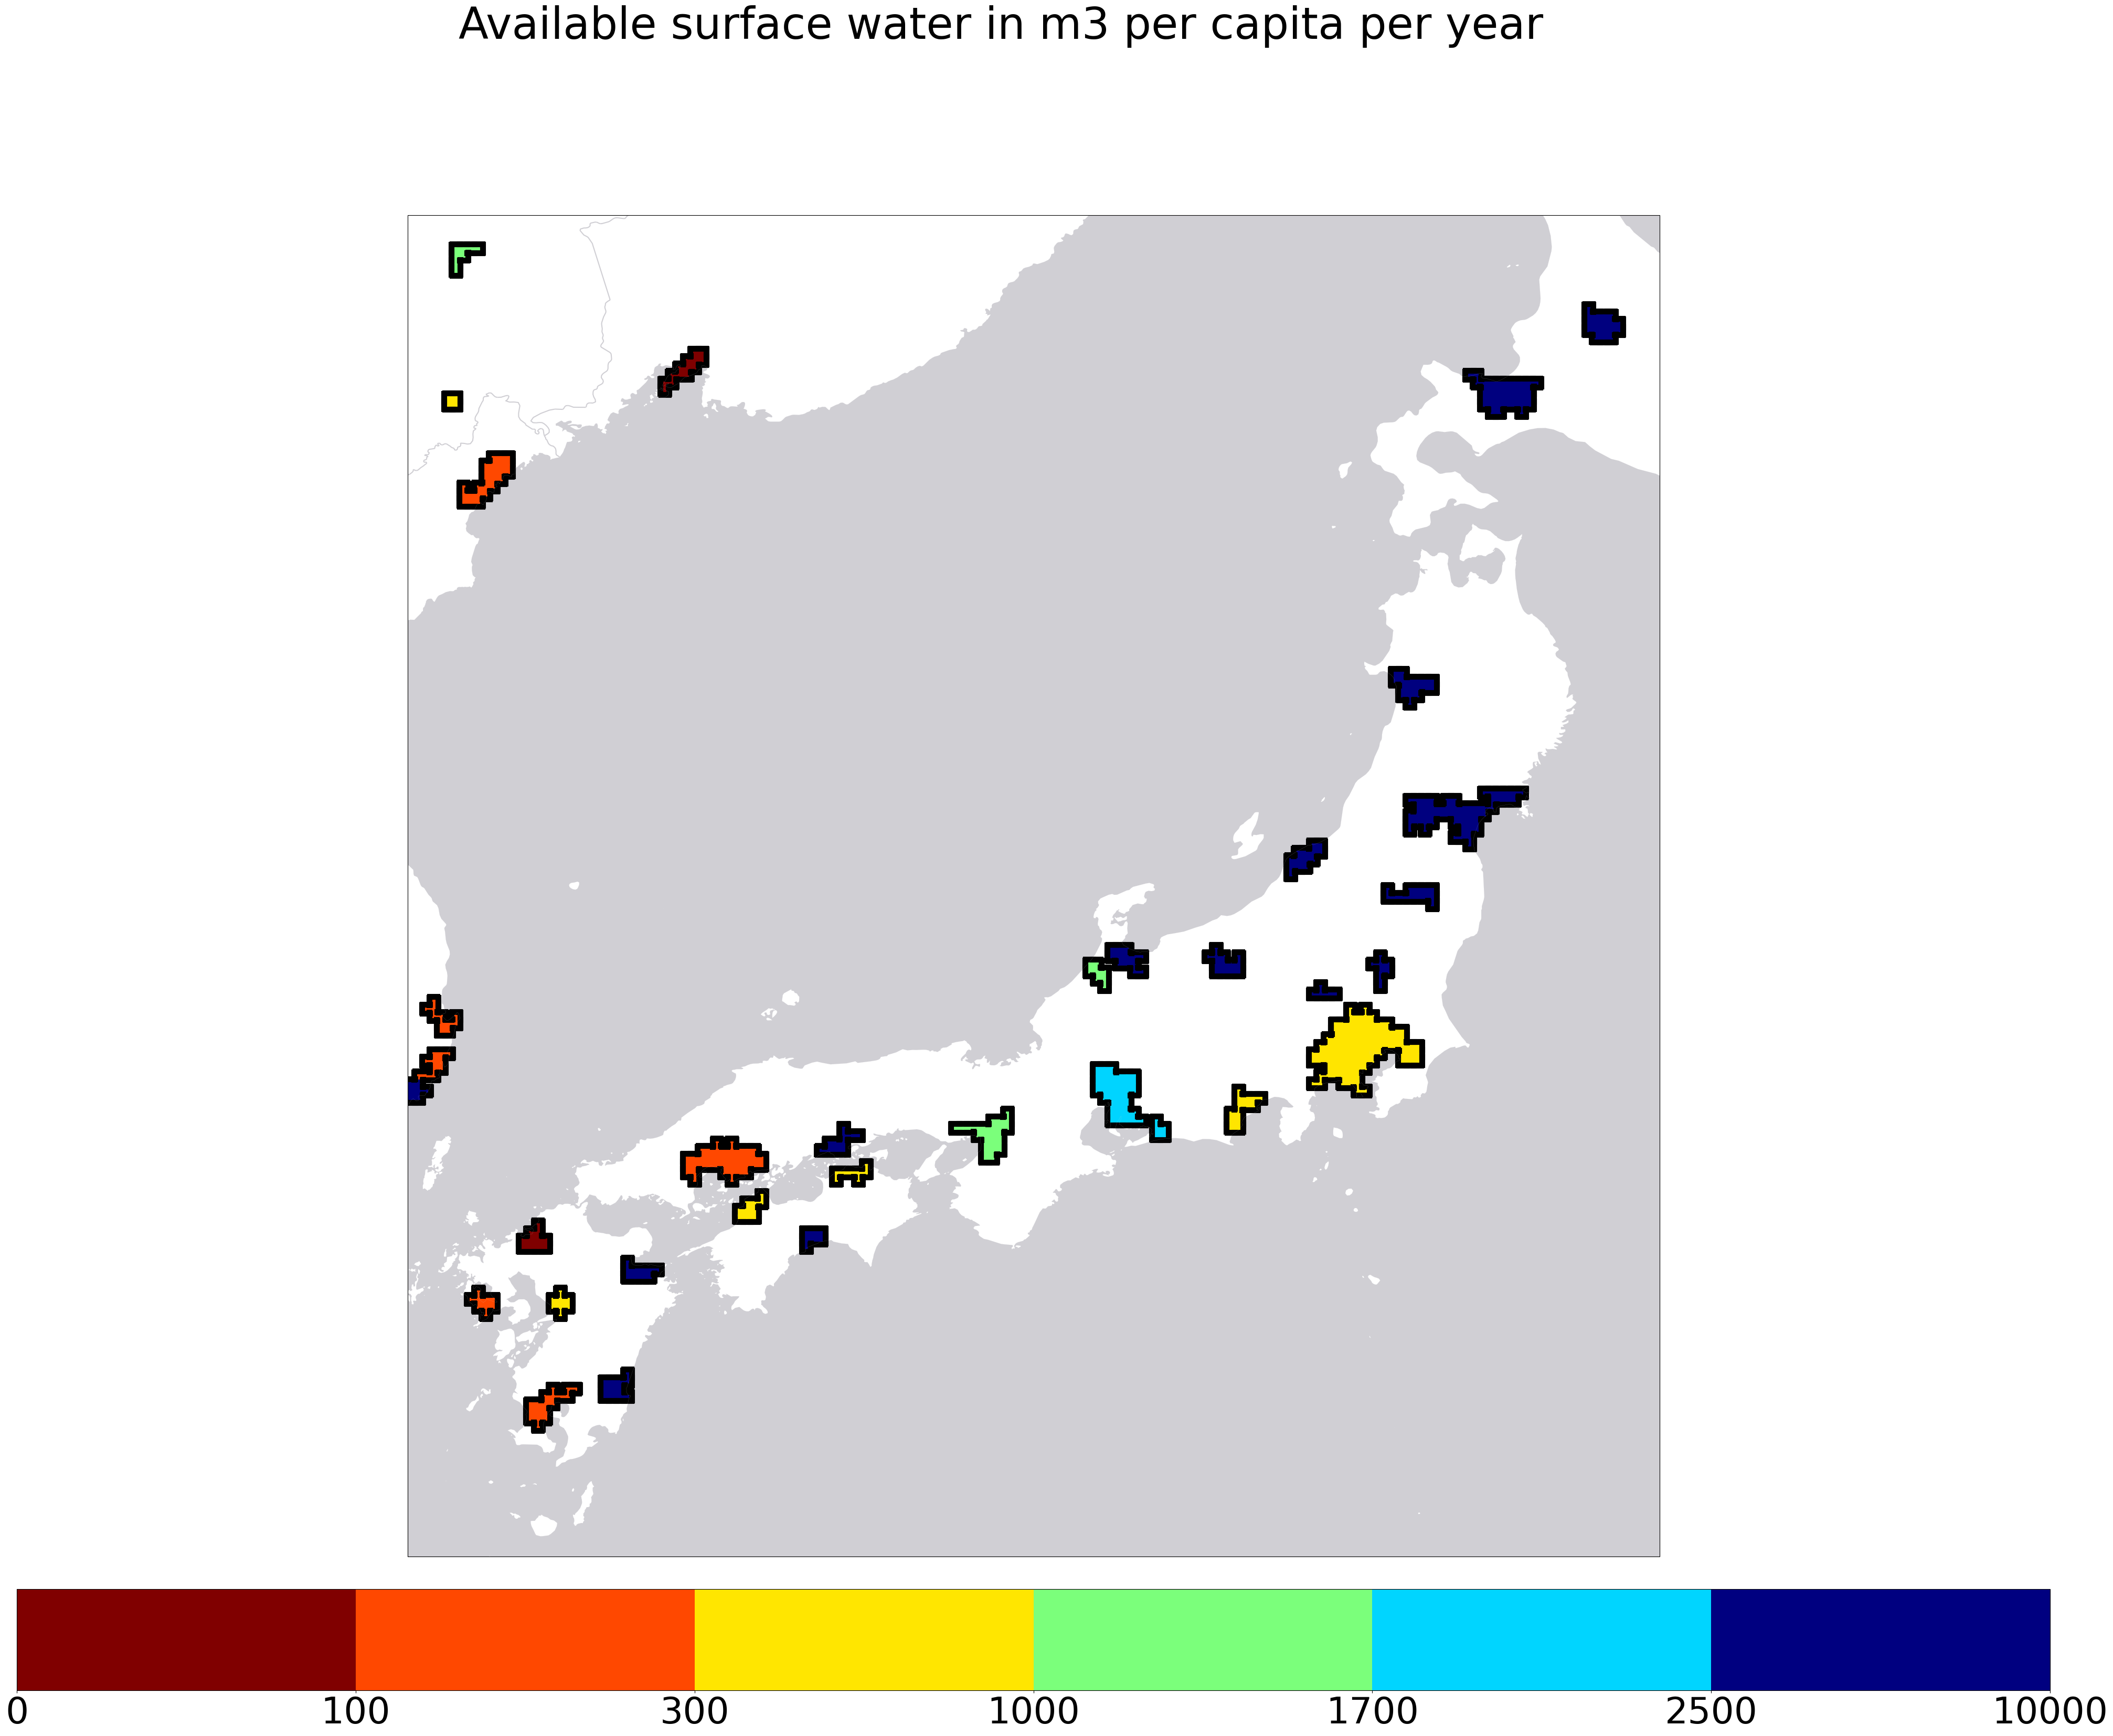

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def draw_mask_sotowaku_outer(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=5, padding=0.1):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    
    extent: (x_left, x_right, y_bottom, y_top)
    mask_cropped: マスクされた都市域の2D配列
    ax: プロットする軸
    sotowaku_color: 枠線の色
    linewidth: 枠線の太さ
    padding: 枠線を外側にシフトさせる量（度単位）
    """
    mask_cropped = np.ma.filled(mask_cropped, 0)

    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] != 0:
                if i > 0 and mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if i < rows-1 and mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if j > 0 and mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if j < cols-1 and mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0]) + padding * delta
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1) - padding * delta
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1]) - padding * delta
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1) + padding * delta
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right

    return ax
    
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(129, 143, 30, 45)

# wsi/pre/population_m3year.ipynb
population_path = f'{h08dir}/wsi/dat/population/population_threshold_world.npy'
population = np.load(population_path)
population_cropped = population[upperindex:lowerindex, leftindex:rightindex]

# wsi/pre/availability_m3year.ipynb
availability_path = f'{h08dir}/wsi/dat/availablewater/availablewater_threshold_world.npy'
availability = np.load(availability_path)
availability_cropped = availability[upperindex:lowerindex, leftindex:rightindex]

# wsi/pre/MPCY_citylonlat_citygrid.ipynb
grid_path = f'{h08dir}/wsi/dat/cmy/world_citygrid.npy'
citygrid = np.load(grid_path)
citygrid_masked = np.ma.masked_where(citygrid==0, citygrid)

region = citygrid_masked[upperindex:lowerindex, leftindex:rightindex]
region_masked = np.ma.masked_where(region==0, region)


threshold = 1e6
bounds = [0, 100, 300, 1000, 1700, 2500, 10000]

cmap = plt.get_cmap('jet_r', len(bounds))  # 10個の離散値
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.rcParams["font.size"] = 50
projection = ccrs.PlateCarree(central_longitude=0)
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(50,40), subplot_kw={'projection': projection})
imd = ax.imshow(region_masked, 
              cmap= cmap,
              norm = norm,
              extent=img_extent,
              transform=ccrs.PlateCarree(), 
             )
ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#ffffff')
ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#d0cfd4')
ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4')
ax.gridlines(visible=False)
cbar = fig.colorbar(imd, ax=ax, orientation='horizontal', pad=0.02)
fig.suptitle('Available surface water in m3 per capita per year')

draw_mask_sotowaku_outer(img_extent, region_masked, ax=ax, sotowaku_color='black', linewidth=8, padding=0.1)
plt.show()

In [93]:
# Crouch 2021 AQUA
# minimum  92 L/capita/day = 33.58 m3/capita/year
# maximum 314 L/capita/day = 114.61 m3/capita/year

# AQUASTAT
# population total of gpwv4.11 = 6,929,592,300
# 4300km3 / 6.929 billion      = 620.58 m3/capita/yeaer    = 1700 L/capita/year
# municipal(11%)               = 68.260 m3/capita/year     = 187.01 L/capita/year
# industry (19%)               = 117.91 m3/capita/year     = 323.04 L/capita/year
# agriculture (70%)            = 434.41 m3/capita/year     = 1190.1 L/capita/year

# Falkenmark 1989
# 1000 m3/capita/year
# municipal (11%)   = 110 m3/capita/yaer = 300 L/capita/day
# industry  (19%)   = 190 m3/capita/year = 518 L/capita/day
# agriculture (70%) = 700 m3/capita/year = 1911 L/capita/day

# Kajiyama 2024
# 1000 m3/capita/year
# municipal   = 100 m3/capita/yaer ≒ 300 L/capita/day
# industry    = 200 m3/capita/year ≒ 500 L/capita/day
# agriculture = 700 m3/capita/year ≒ 2000 L/capita/day

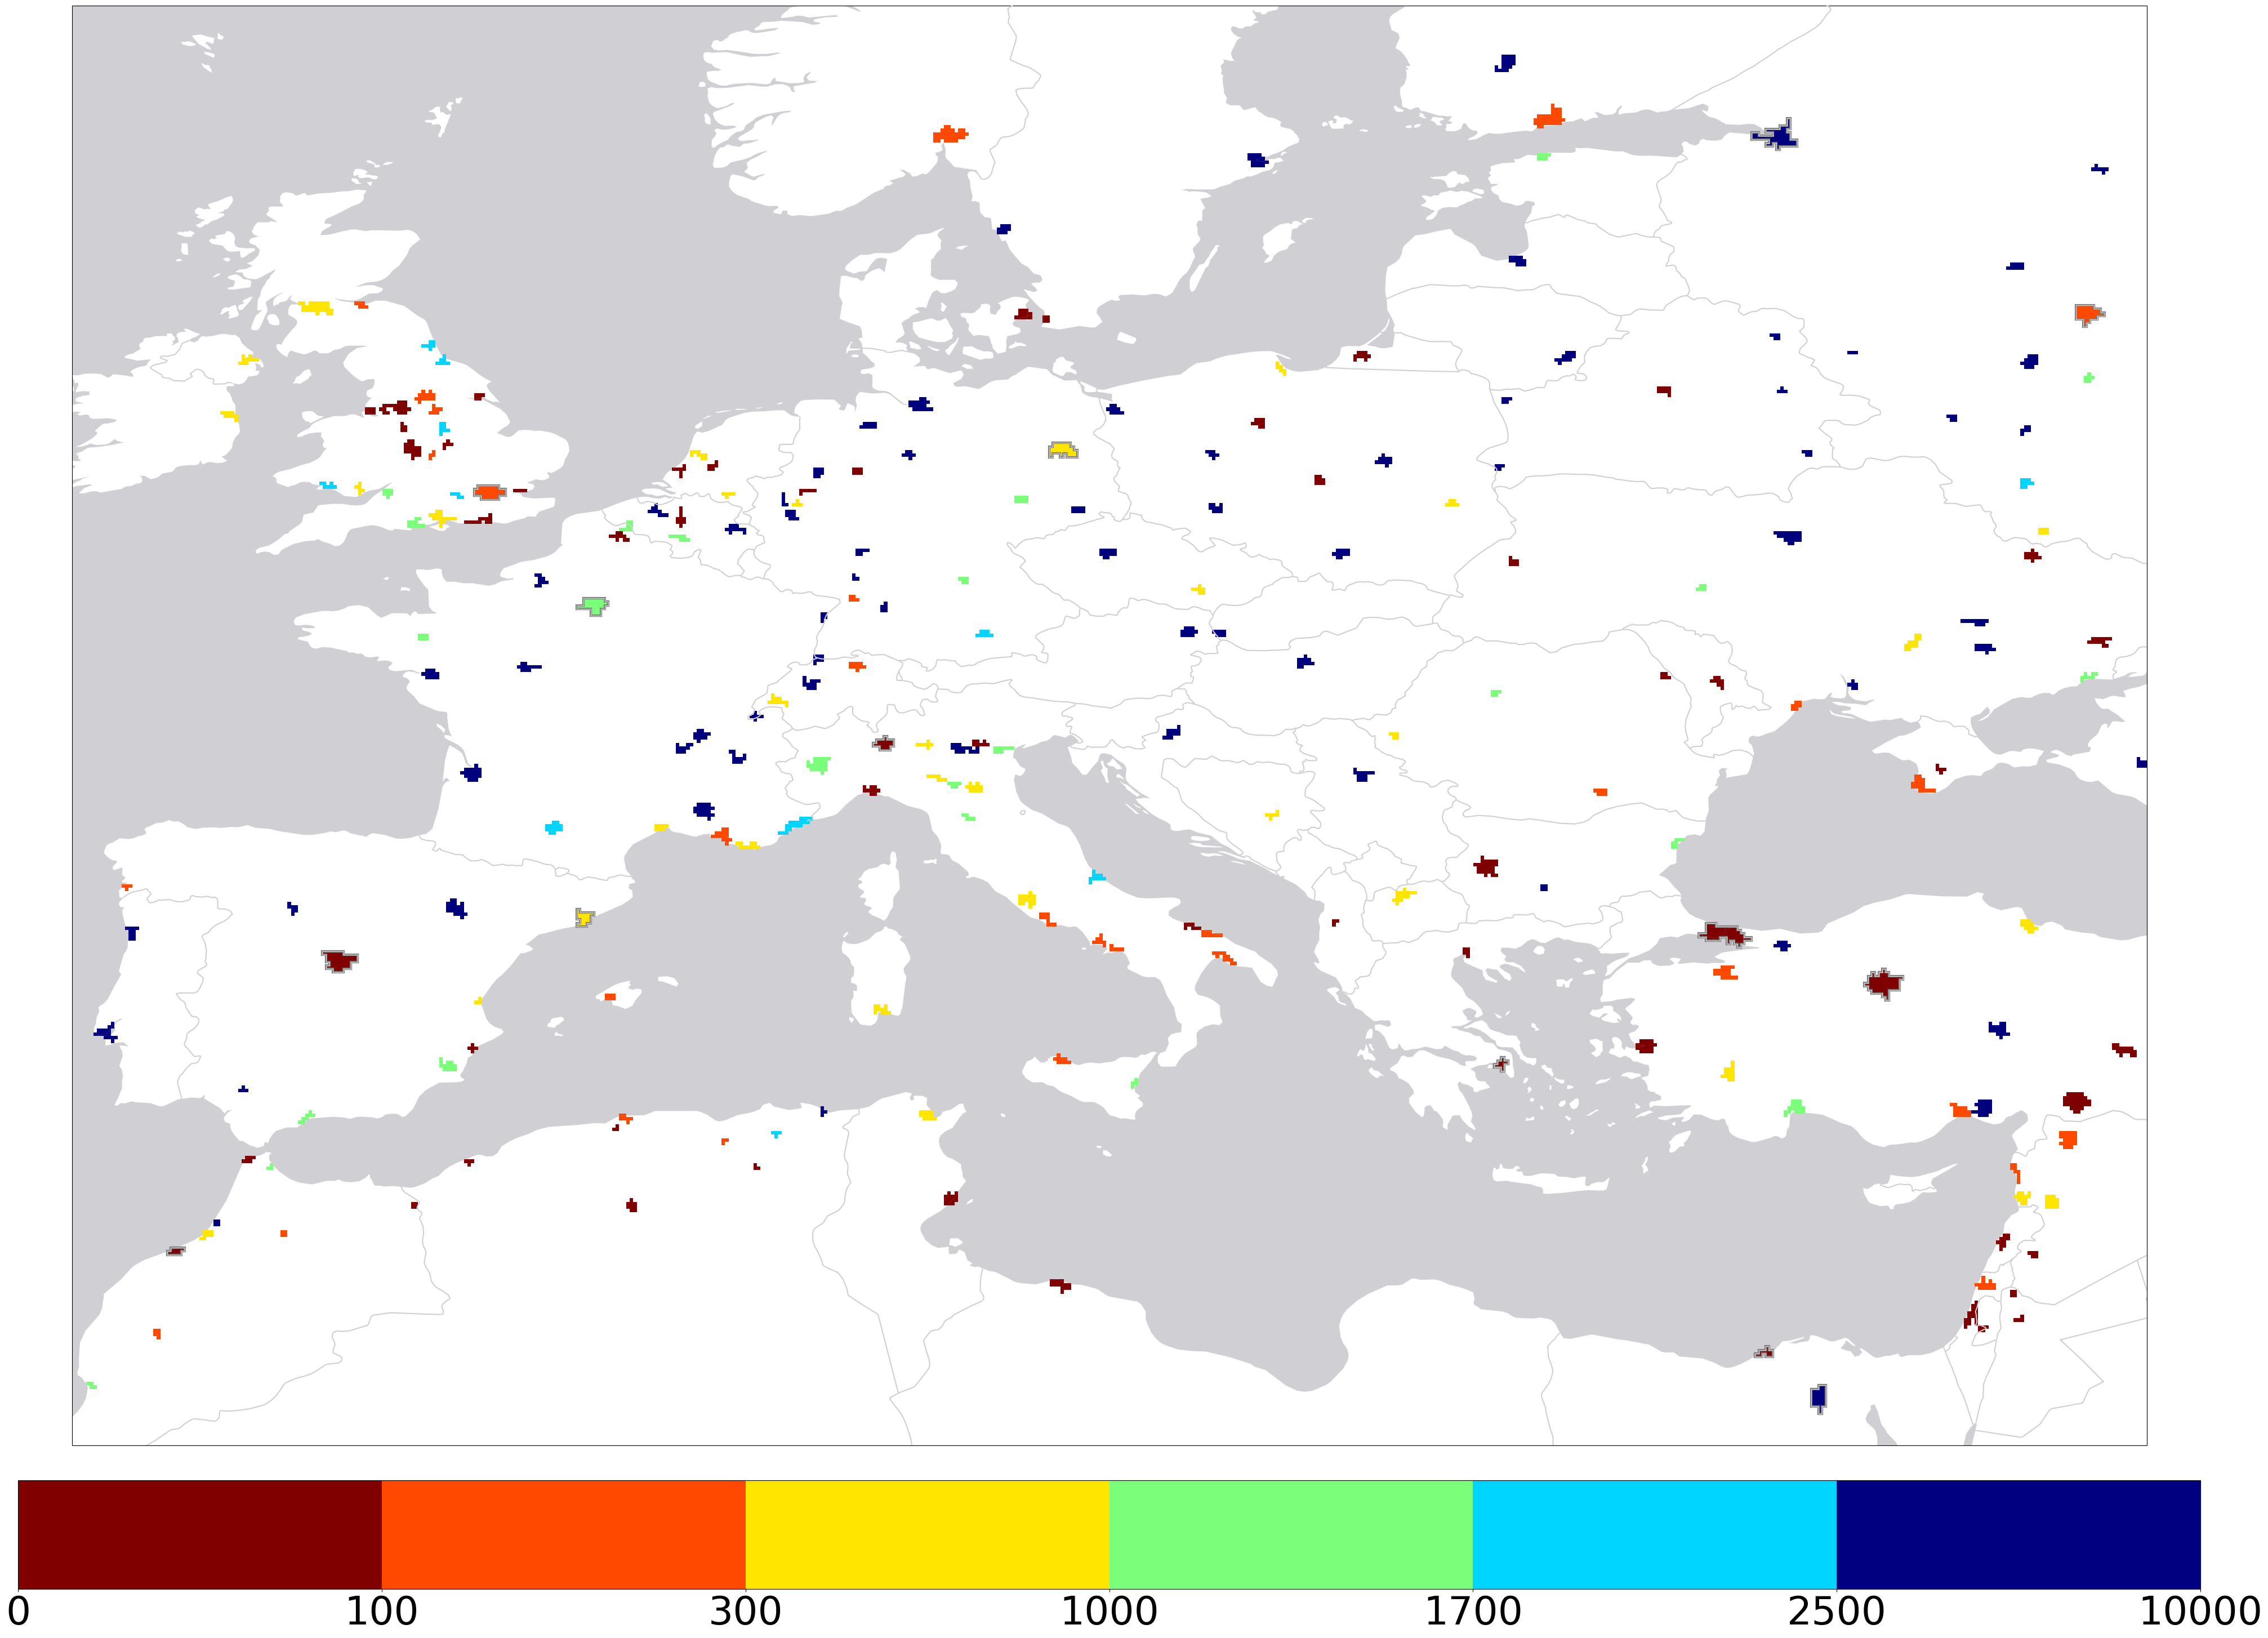

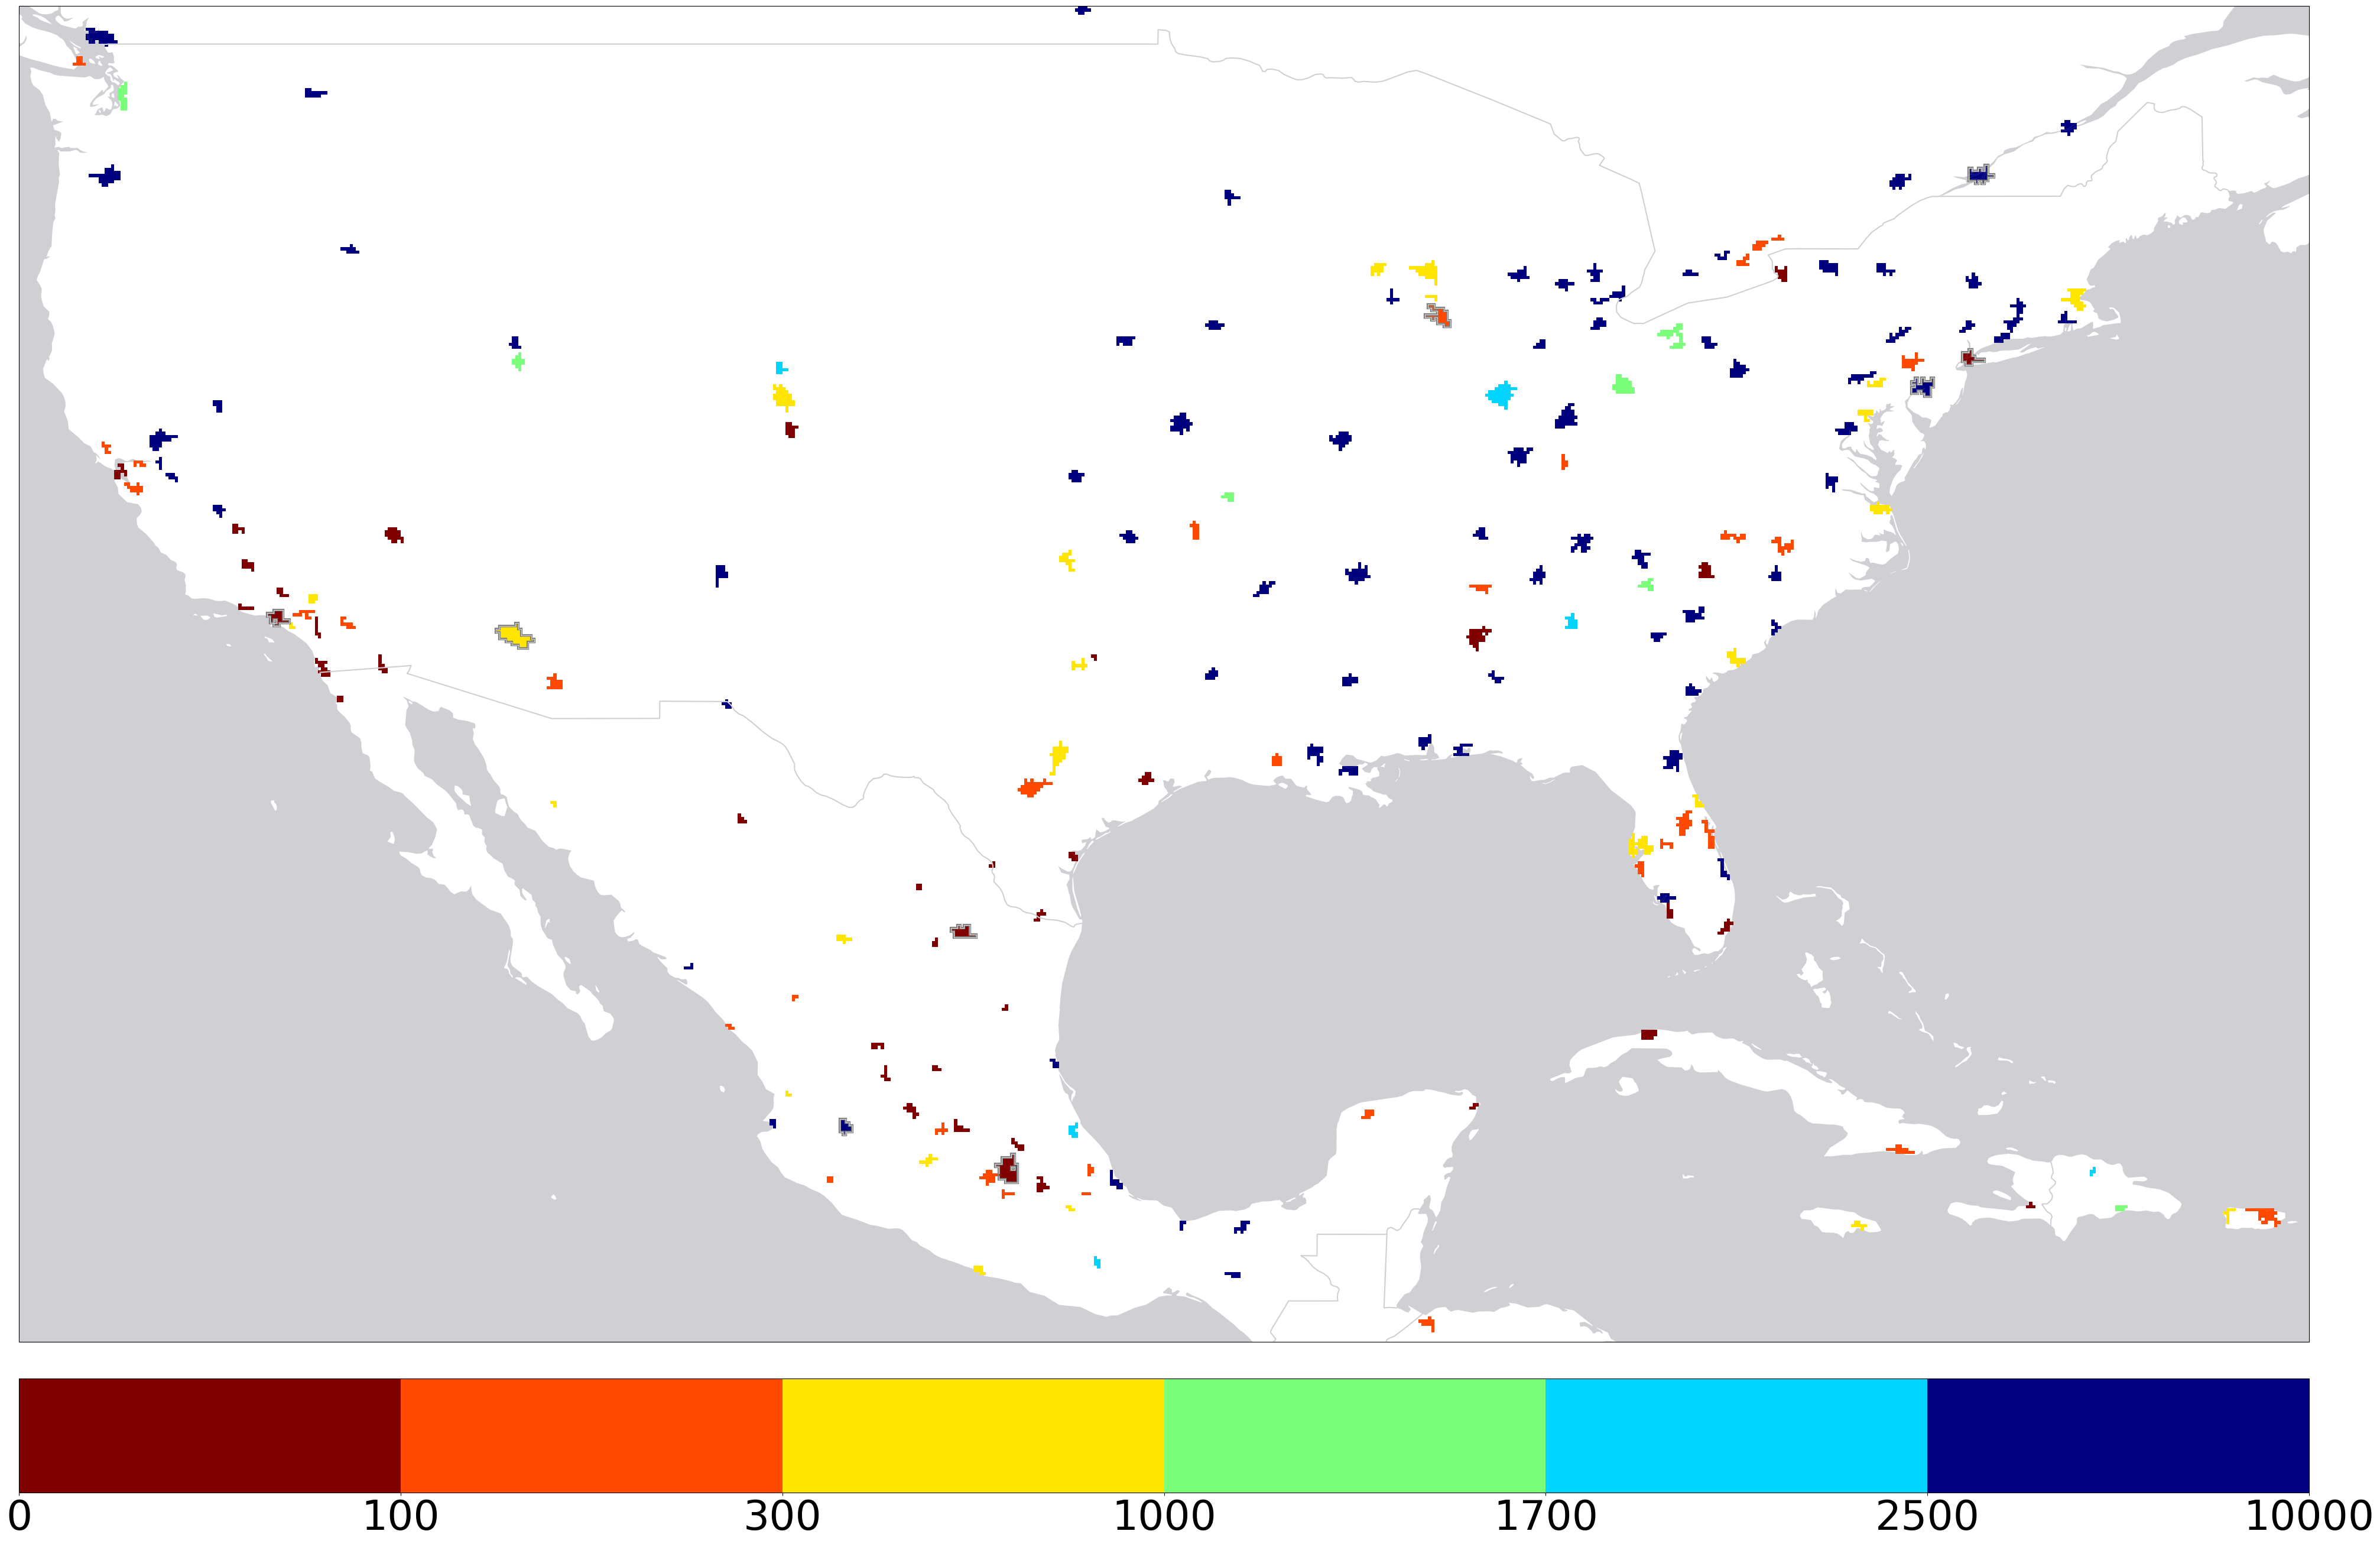

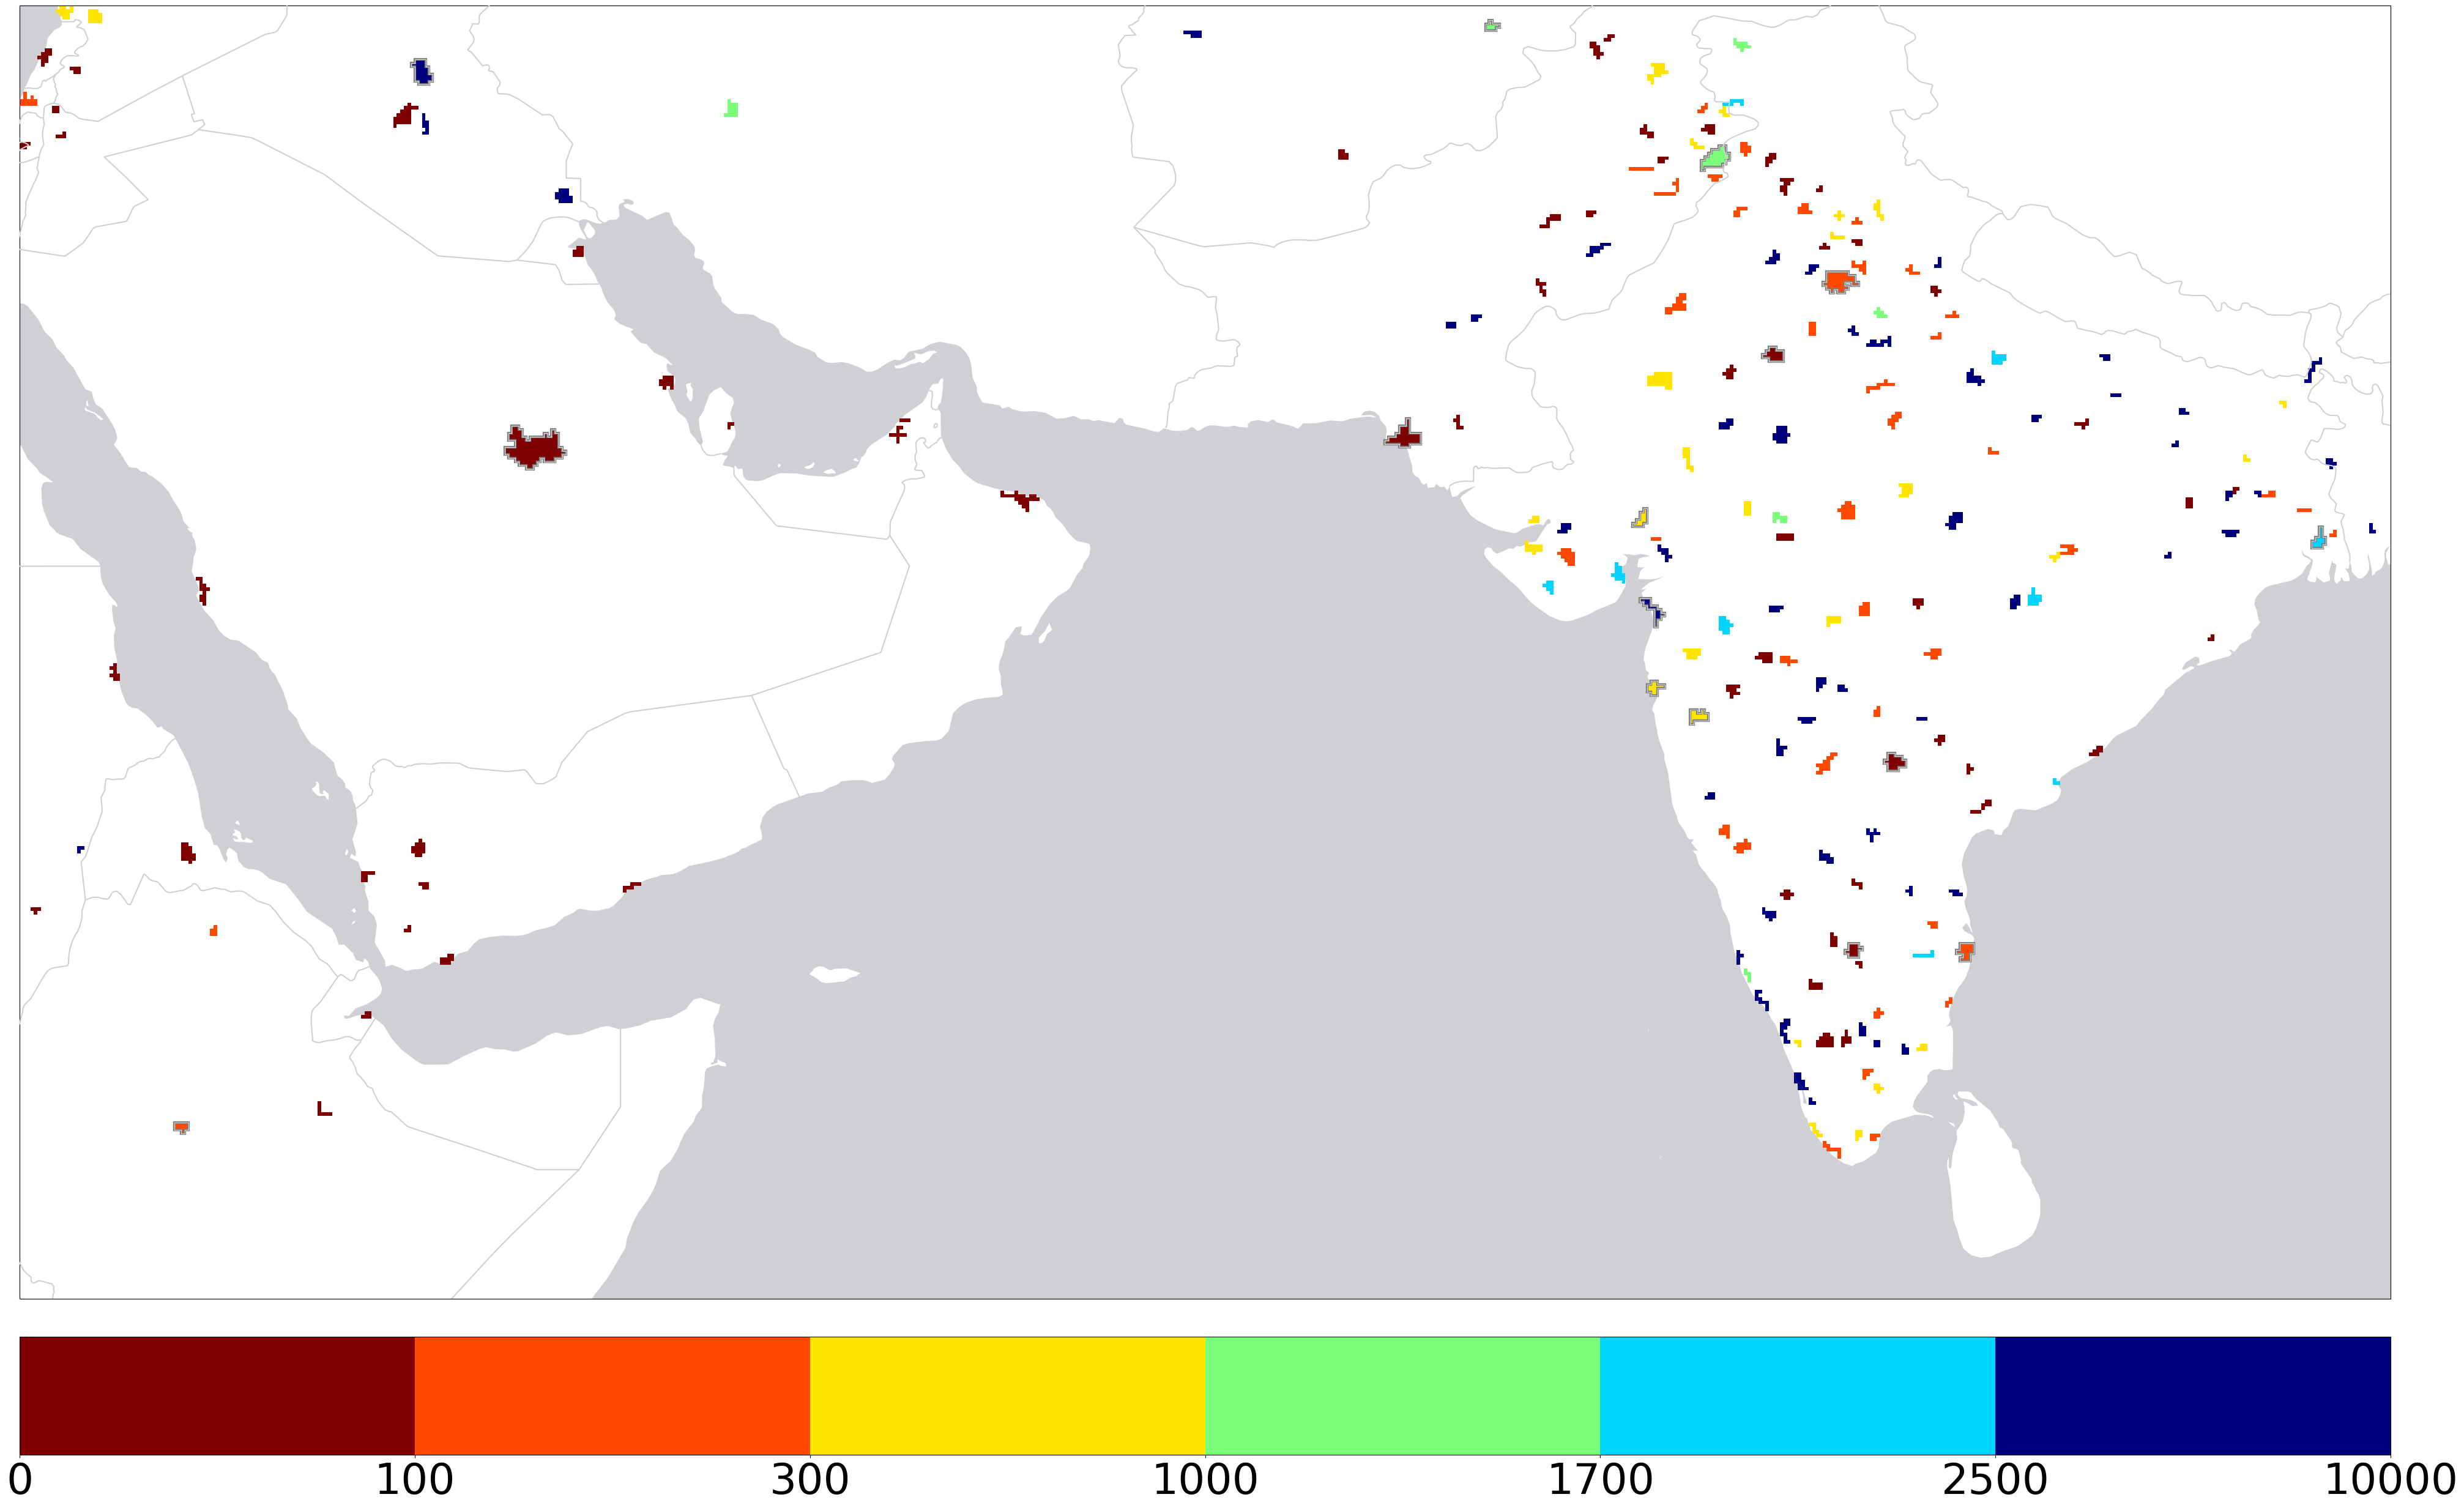

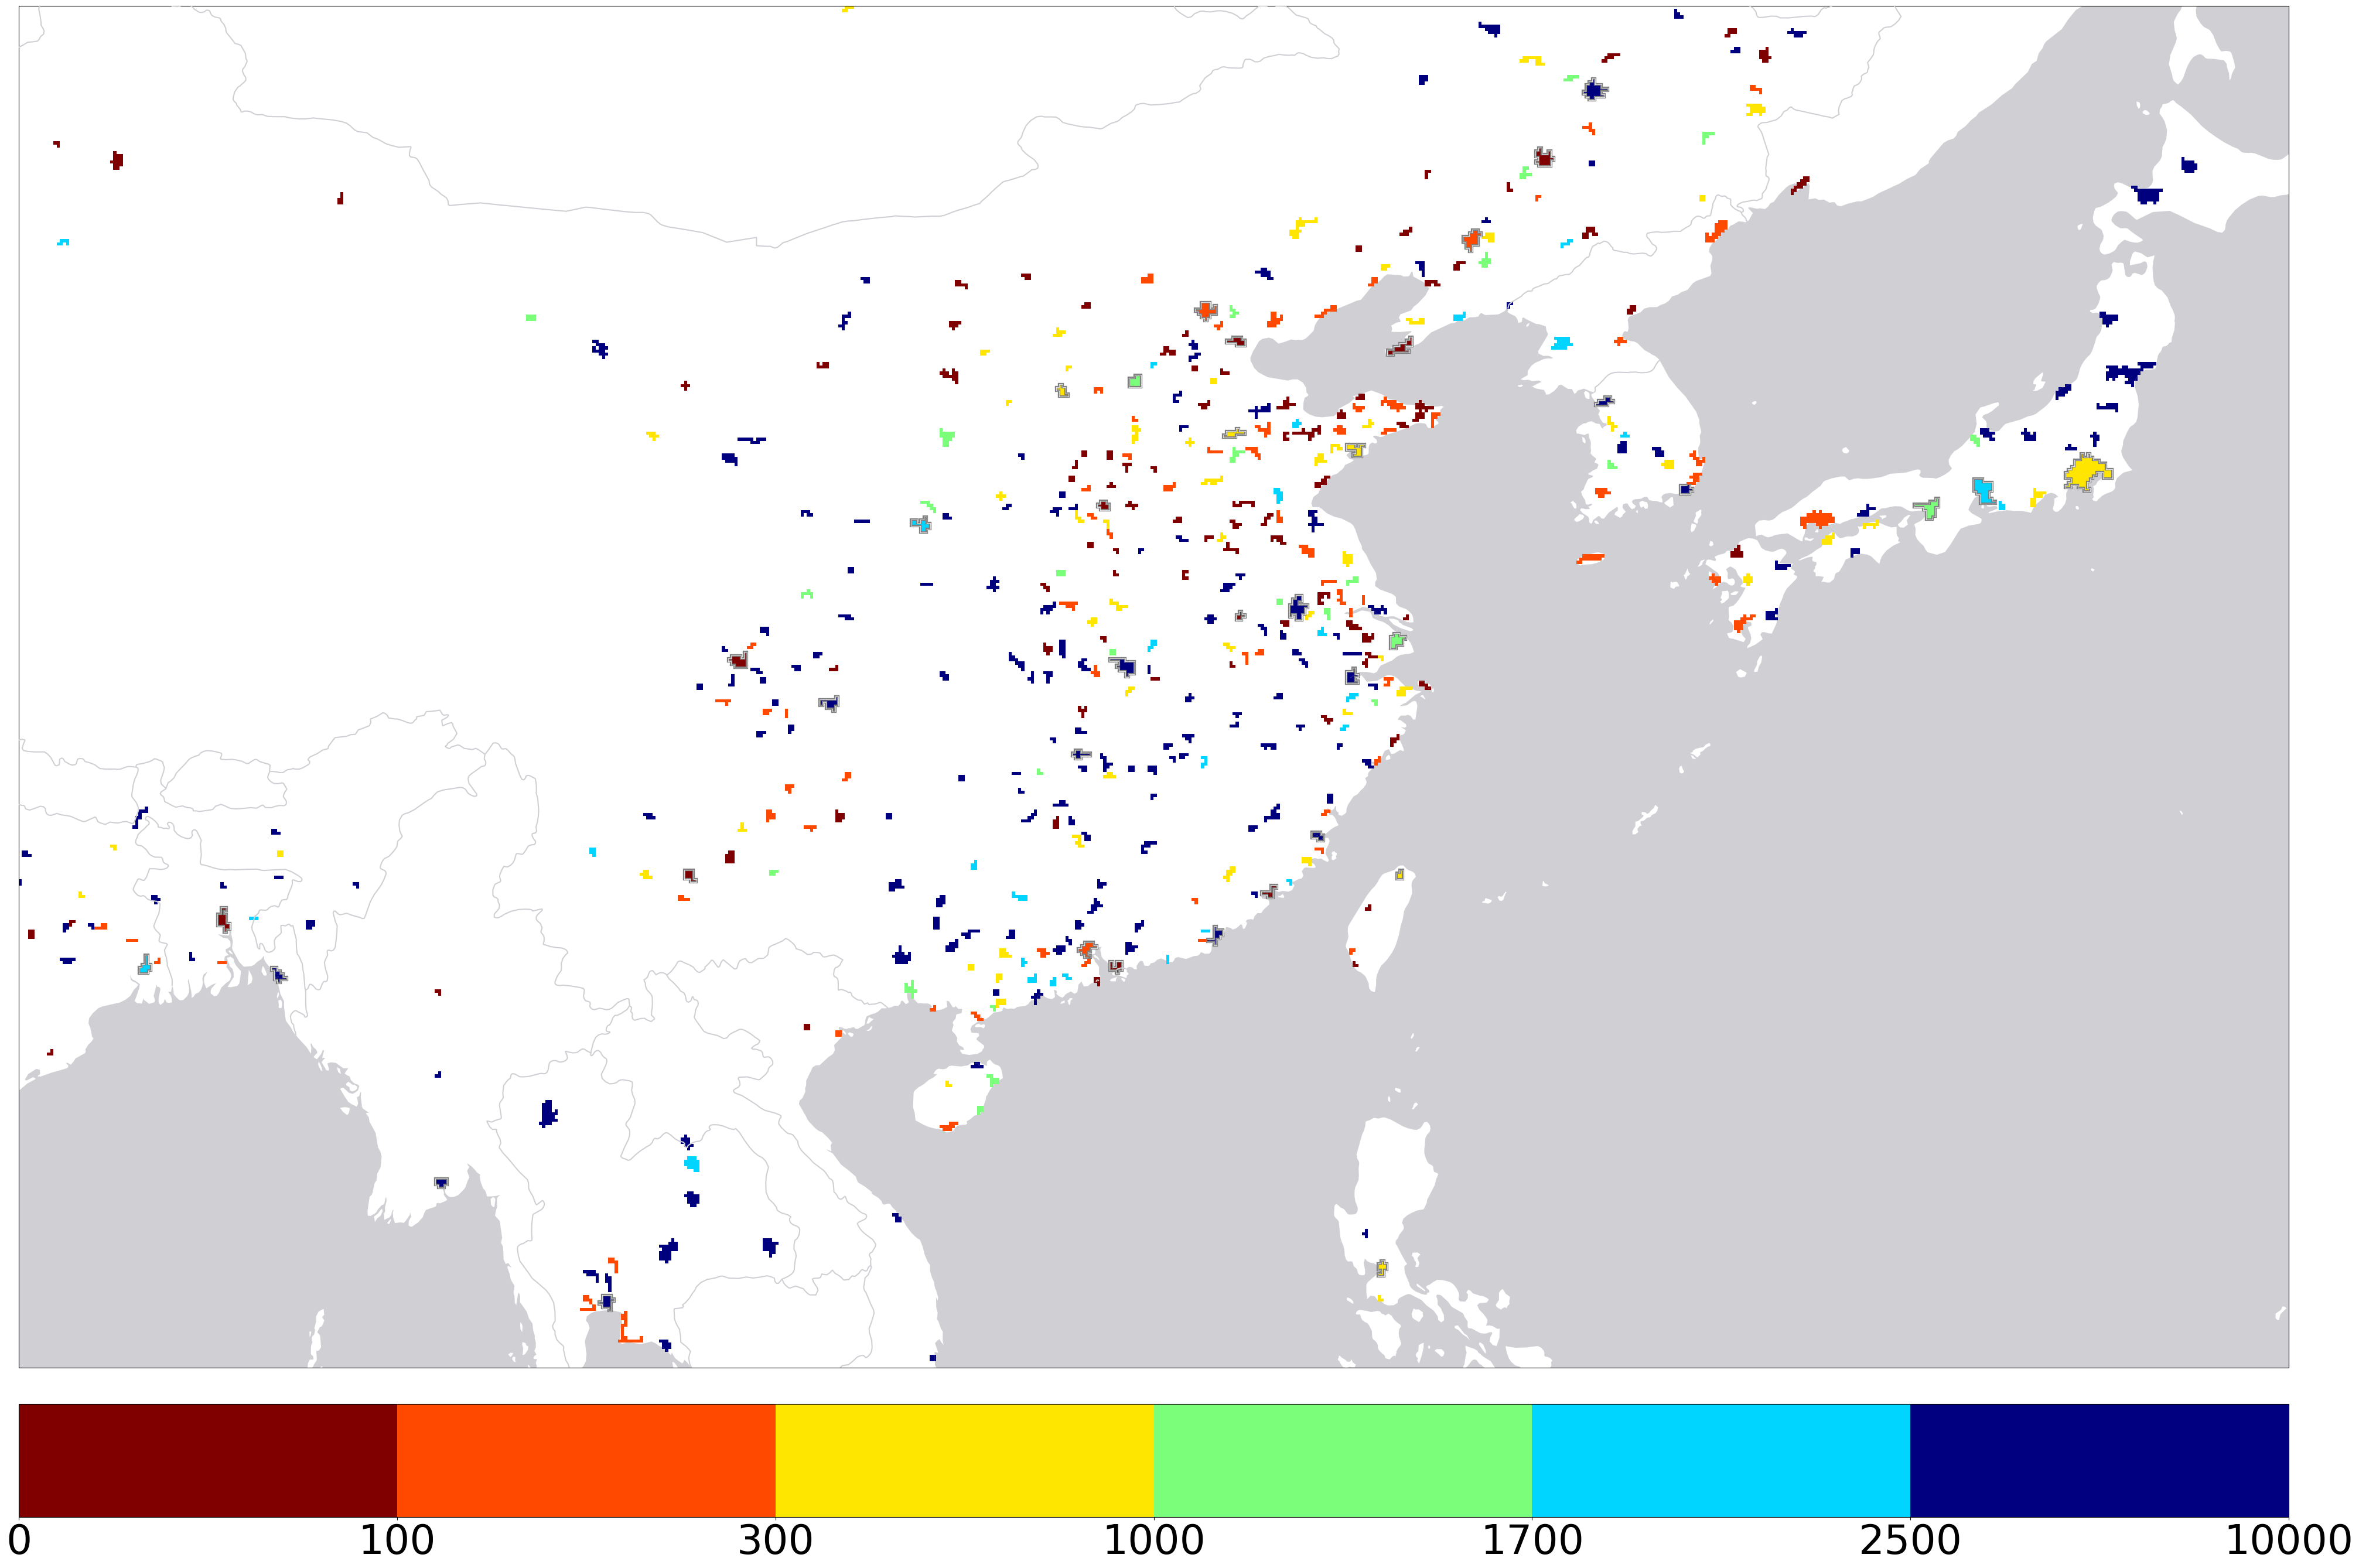

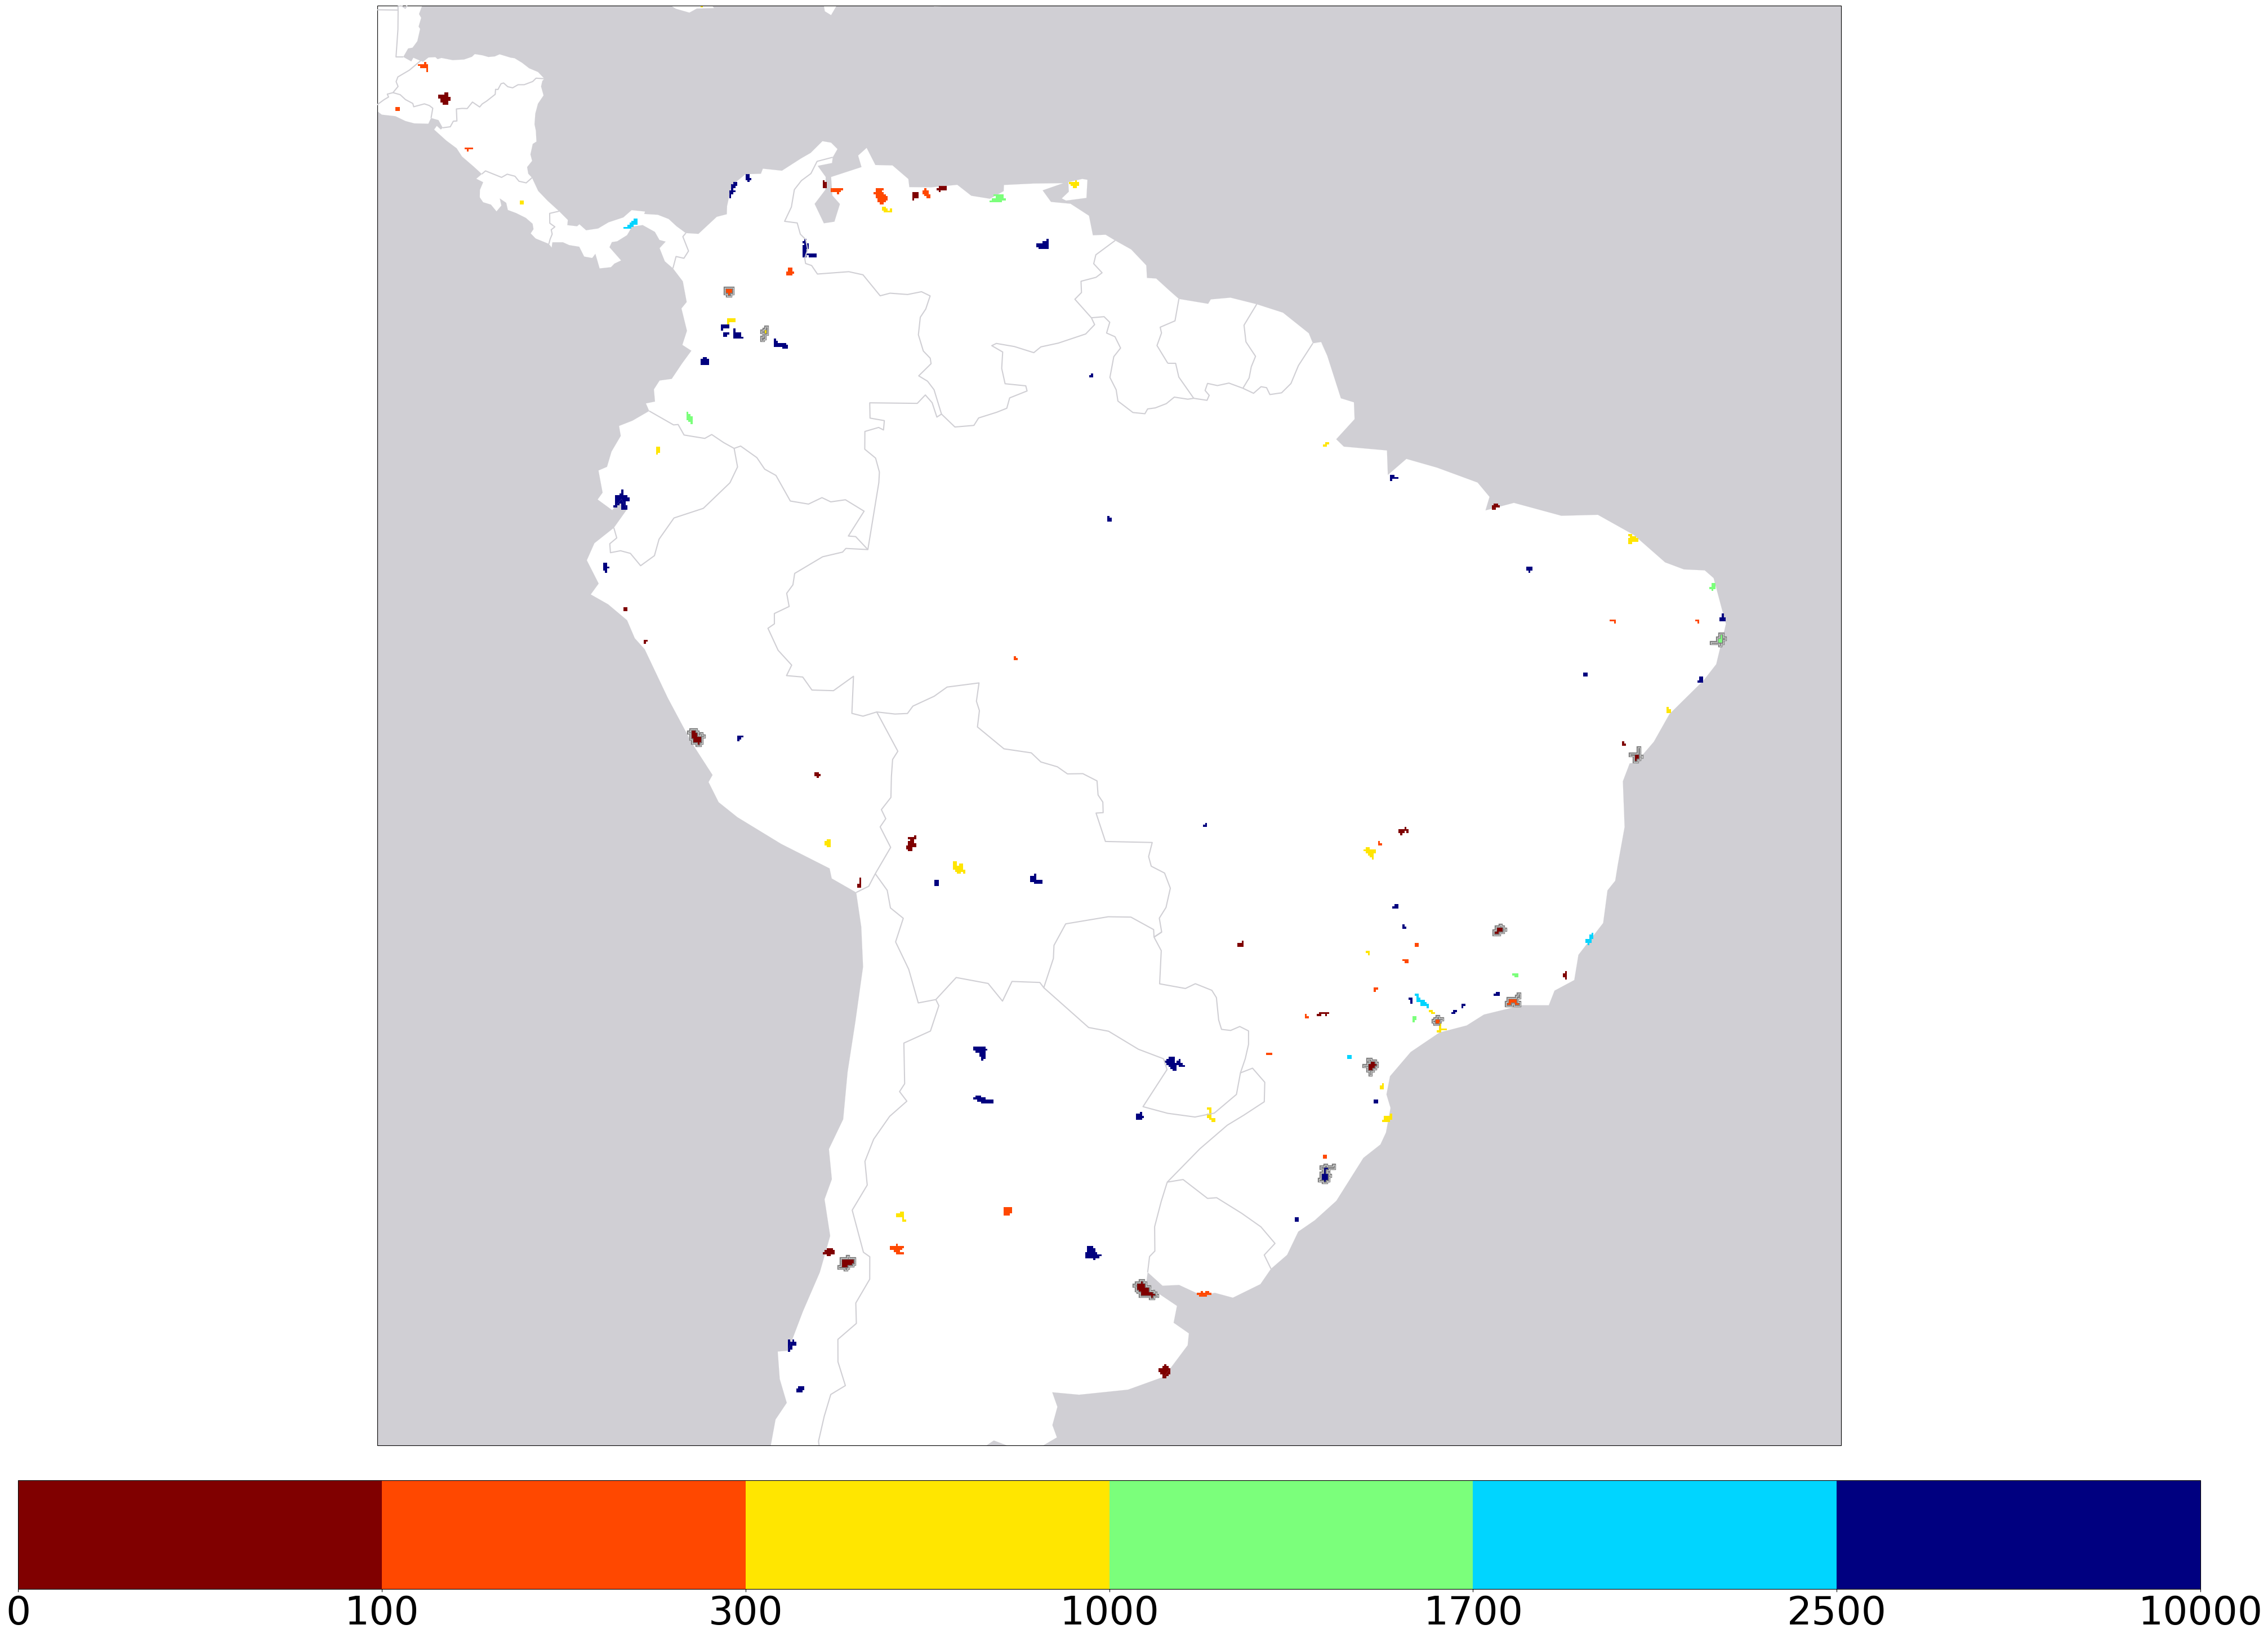

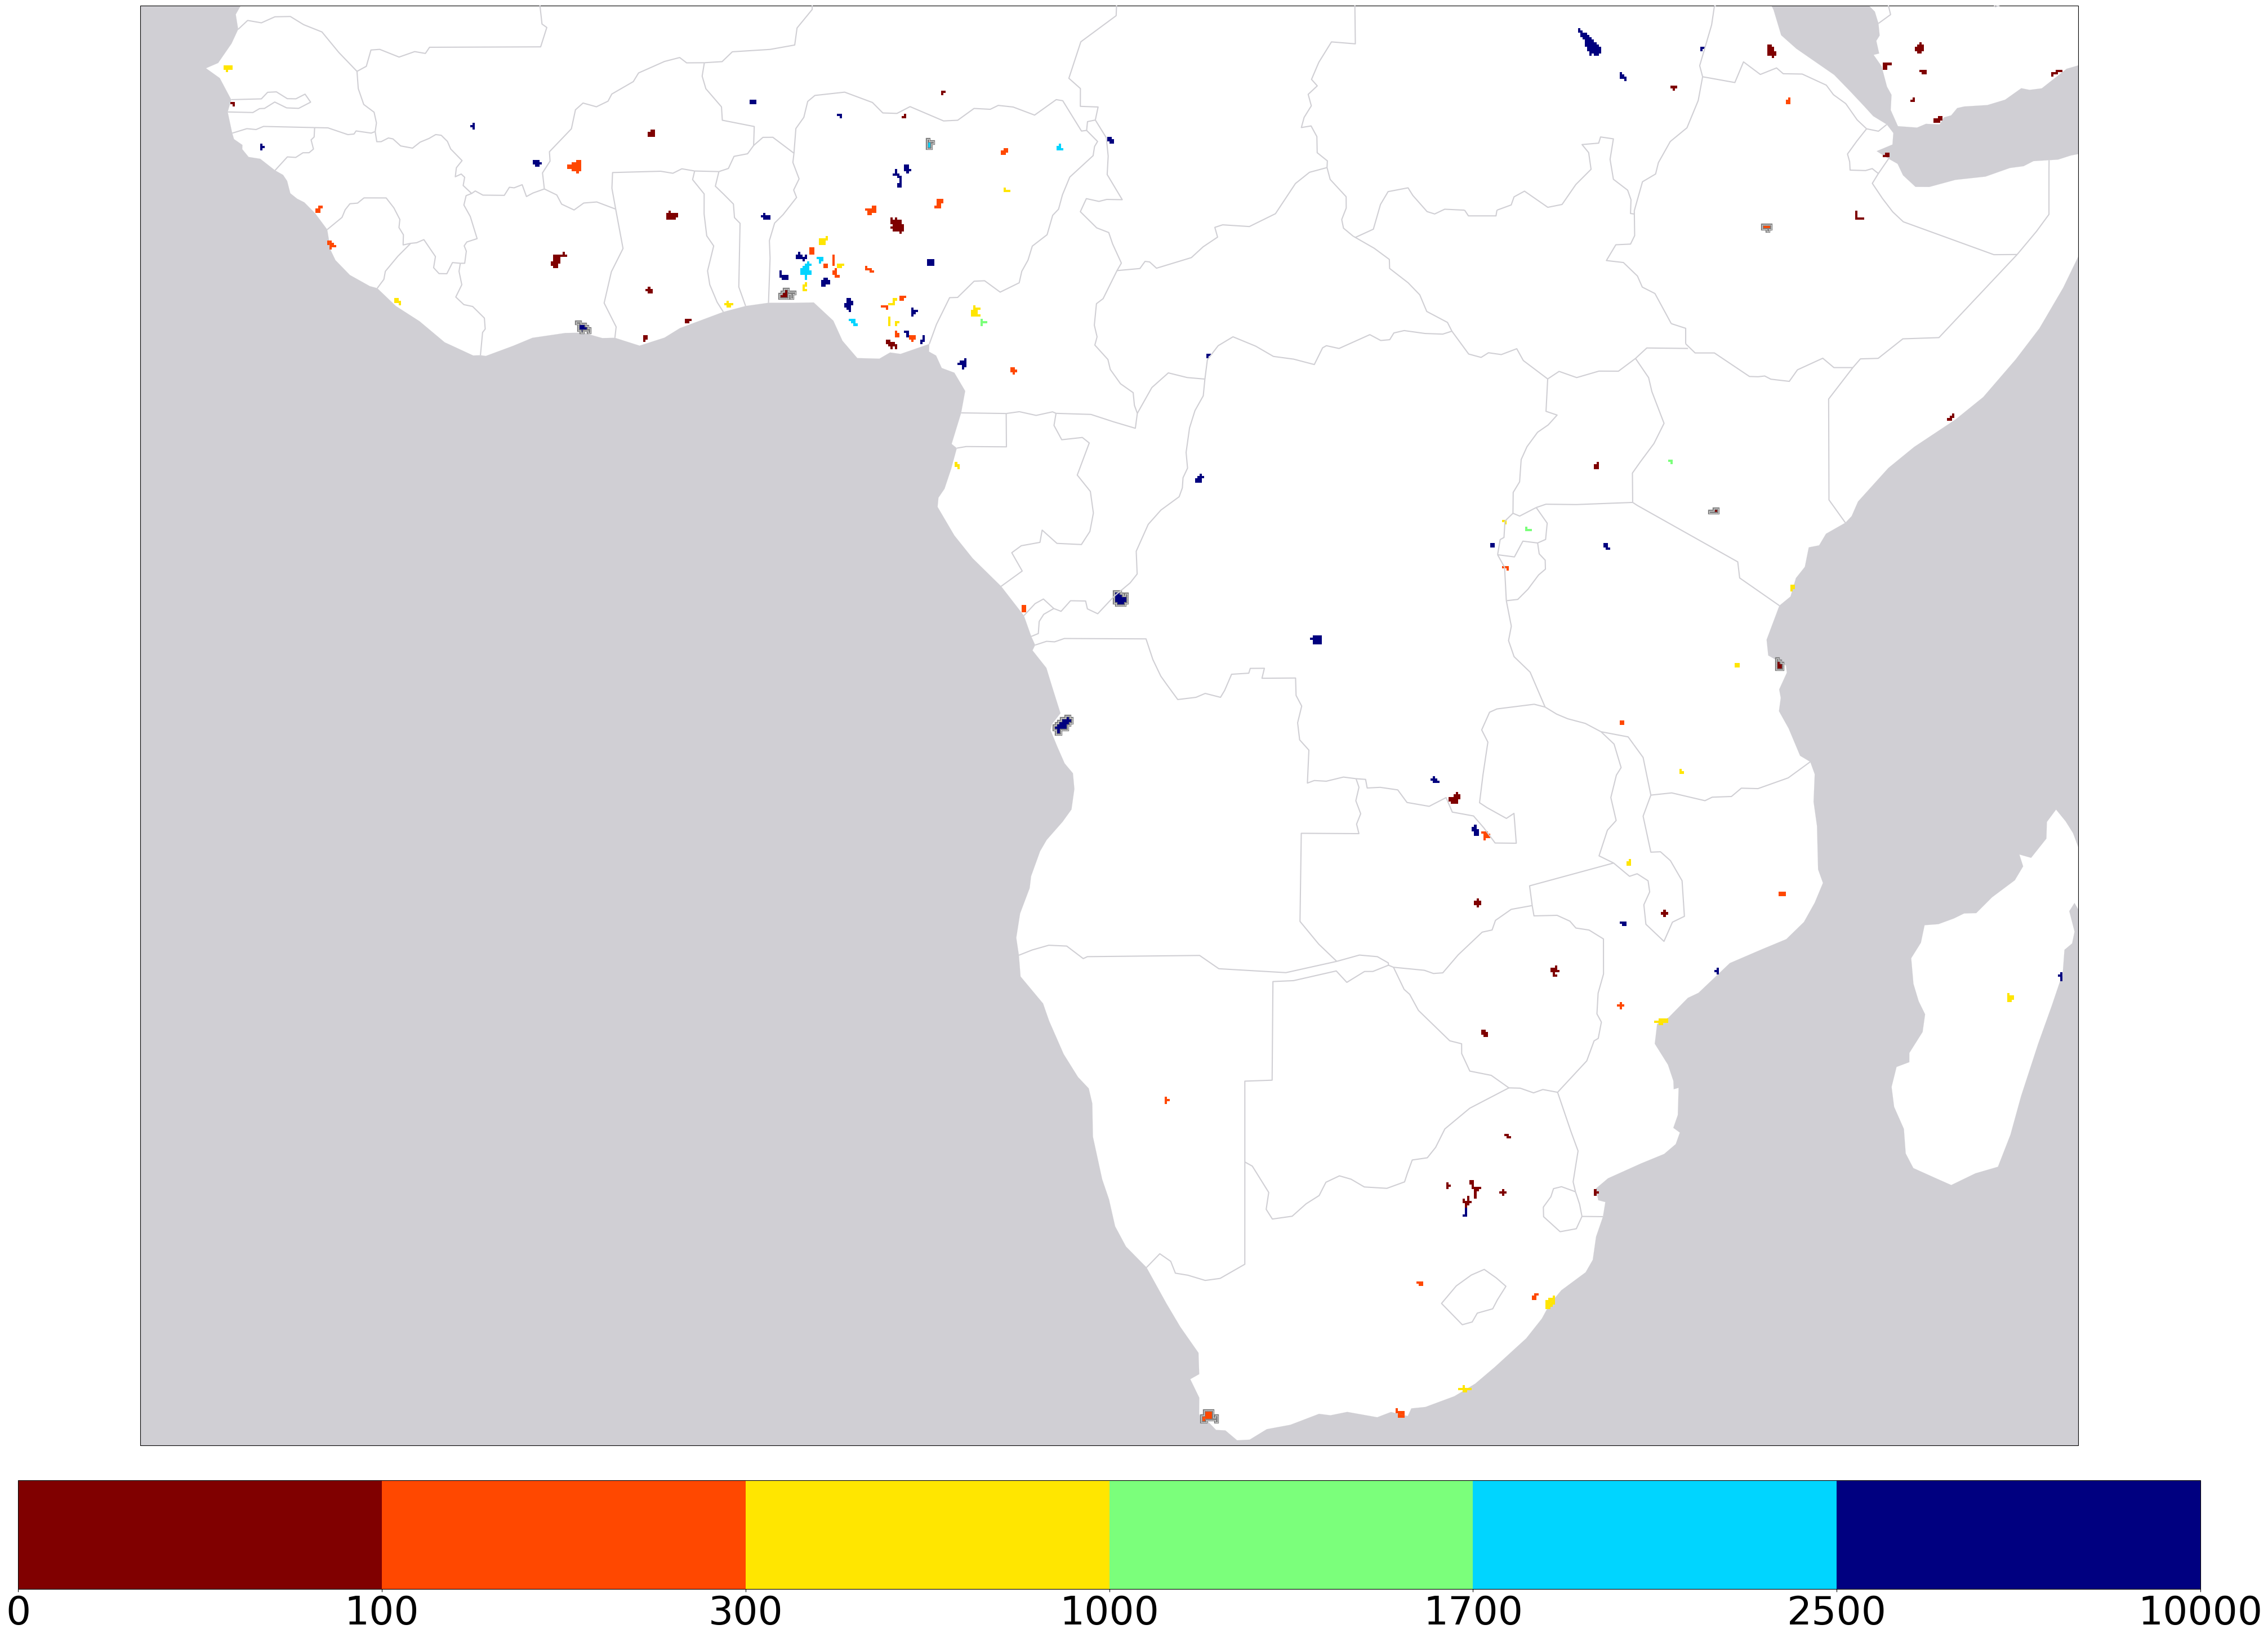

In [49]:
#---------------------------------------------------------------------------------------------------------------
# Population > 3,000,000
#---------------------------------------------------------------------------------------------------------------
def draw_mask_sotowaku(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=3, subwidth=1):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    zorder = 2: 白色の内枠が最前面(citymask)
    """
    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] > 3*1e6 and mask_cropped[i, j] != 0:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
        ax.plot([x_index, x_index+delta], [y_index, y_index], color='white', transform=projection, linewidth=subwidth, zorder=2) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
        ax.plot([x_index, x_index+delta], [y_index, y_index], color='white', transform=projection, linewidth=subwidth, zorder=2) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
        ax.plot([x_index, x_index], [y_index, y_index+delta], color='white', transform=projection, linewidth=subwidth, zorder=2) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right
        ax.plot([x_index, x_index], [y_index, y_index+delta], color='white', transform=projection, linewidth=subwidth, zorder=2) # right

    return ax

def tmp_plot(left, right, bottom, top):
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)
    population_cropped = population[upperindex:lowerindex, leftindex:rightindex]
    region = citygrid_masked[upperindex:lowerindex, leftindex:rightindex]
    region_masked = np.ma.masked_where(region==0, region)
    
    threshold = 1e6
    bounds = [0, 100, 300, 1000, 1700, 2500, 10000]
    
    cmap = plt.get_cmap('jet_r', len(bounds))  # 10個の離散値
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    plt.rcParams["font.size"] = 50
    projection = ccrs.PlateCarree(central_longitude=0)
    crs = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(50,40), subplot_kw={'projection': projection})
    imd = ax.imshow(region_masked, 
                  cmap= cmap,
                  norm = norm,
                  extent=img_extent,
                  transform=ccrs.PlateCarree(), 
                 )
    #ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea')
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#d0cfd4')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=5)
    ax.gridlines(visible=False)
    cbar = fig.colorbar(imd, ax=ax, orientation='horizontal', pad=0.02)
    #fig.suptitle('Available surface water in m3 per capita per year')
    draw_mask_sotowaku(img_extent, population_cropped, ax=ax, sotowaku_color='grey', linewidth=3, subwidth=0.5)
    plt.show()
    
tmp_plot(-10, 39, 29, 63)
tmp_plot(-125, -65, 15, 50)
tmp_plot(35 ,90, 5, 35)
tmp_plot(85, 145, 12, 48)
tmp_plot(-90, -30, -41, 18)
tmp_plot(-20, 50, -35, 17)

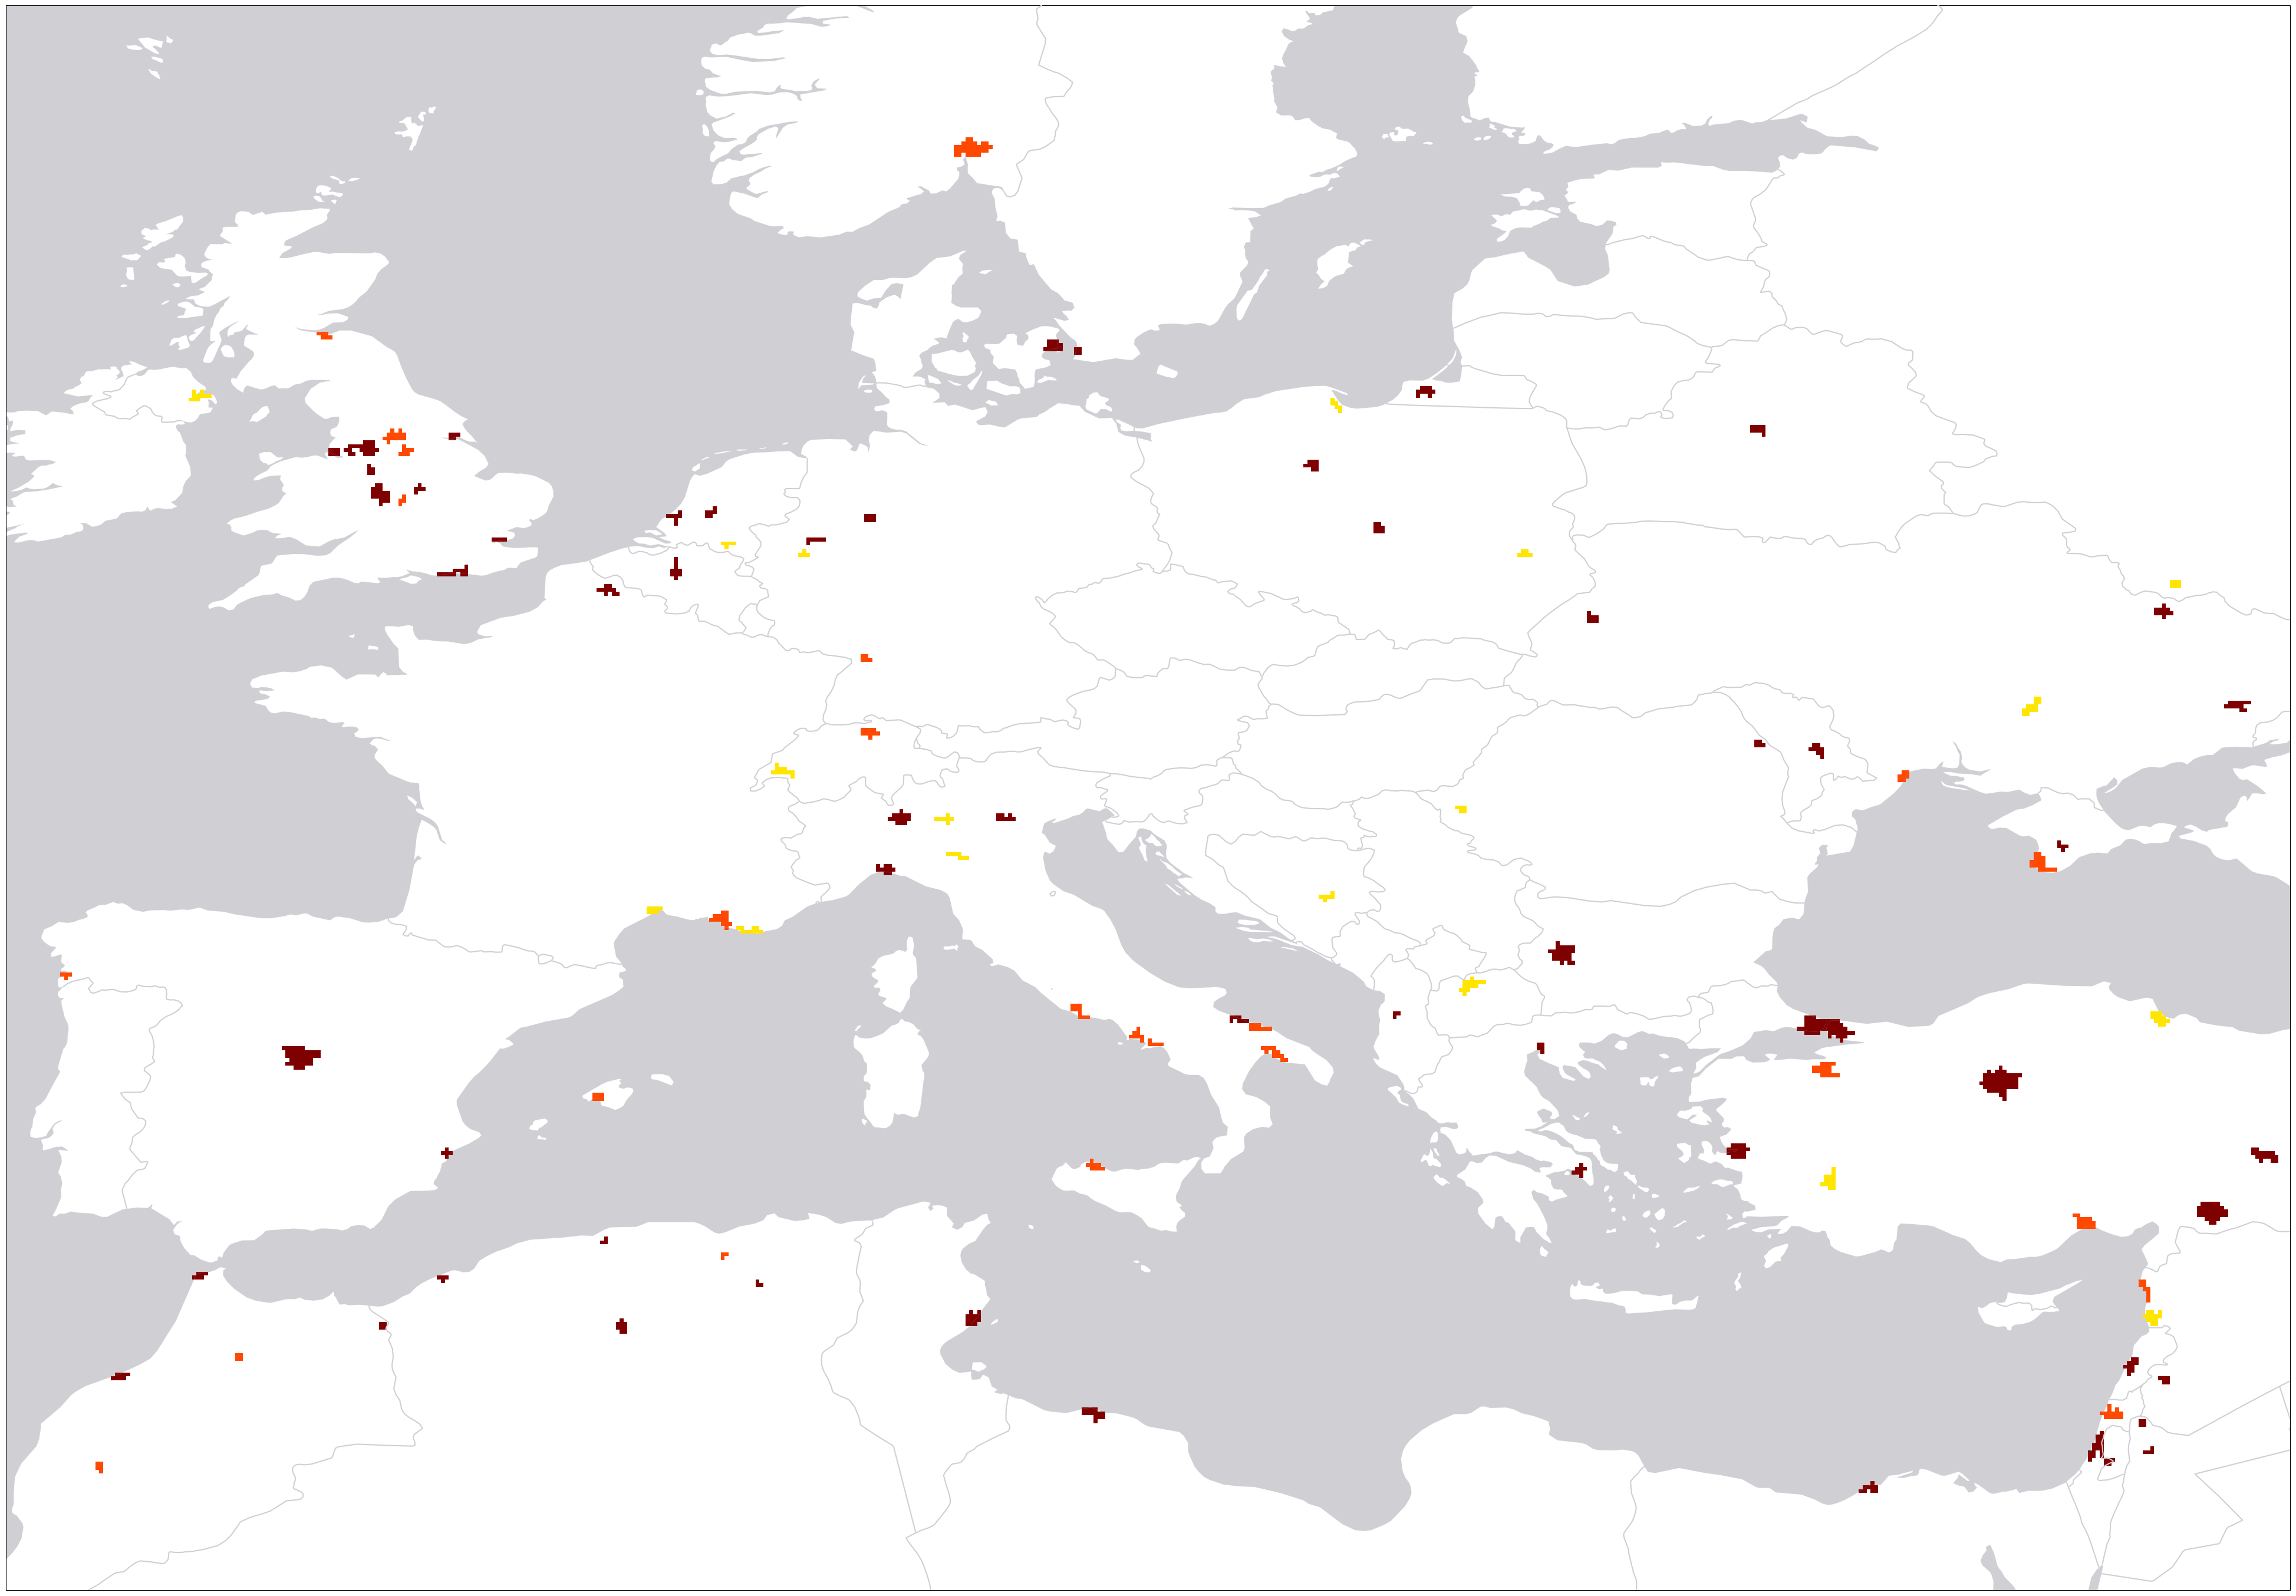

In [48]:
#---------------------------------------------------------------------------------------------------------------
#  population > 3,000,000 water availability < 300,000,000
#---------------------------------------------------------------------------------------------------------------
def draw_mask_sotowaku(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=3, subwidth=1):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    zorder = 2: 白色の内枠が最前面(citymask)
    """
    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] > 3000*1e6 and mask_cropped[i, j] != 0:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
        ax.plot([x_index, x_index+delta], [y_index, y_index], color='white', transform=projection, linewidth=subwidth, zorder=2) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
        ax.plot([x_index, x_index+delta], [y_index, y_index], color='white', transform=projection, linewidth=subwidth, zorder=2) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
        ax.plot([x_index, x_index], [y_index, y_index+delta], color='white', transform=projection, linewidth=subwidth, zorder=2) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right
        ax.plot([x_index, x_index], [y_index, y_index+delta], color='white', transform=projection, linewidth=subwidth, zorder=2) # right

    return ax
    
upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(-10, 39, 29, 63)
availability_cropped = availability[upperindex:lowerindex, leftindex:rightindex]
population_cropped = population[upperindex:lowerindex, leftindex:rightindex]
region = citygrid_masked[upperindex:lowerindex, leftindex:rightindex]
region_masked = np.ma.masked_where(region==0, region)
region_pop = np.ma.masked_where(population_cropped < 3*1e6, region_masked)
region_ava = np.ma.masked_where(availability_cropped > 300*1e6, region_masked)

bounds = [0, 100, 300, 1000, 1700, 2500, 10000]

cmap = plt.get_cmap('jet_r', len(bounds))  # 10個の離散値
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.rcParams["font.size"] = 50
projection = ccrs.PlateCarree(central_longitude=0)
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(50,40), subplot_kw={'projection': projection})
imd = ax.imshow(region_ava, 
              cmap= cmap,
              norm = norm,
              extent=img_extent,
              transform=ccrs.PlateCarree(), 
             )
#ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea')
ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#ffffff')
ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#d0cfd4')
ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=5)
ax.gridlines(visible=False)
#cbar = fig.colorbar(imd, ax=ax, orientation='horizontal', pad=0.02)
#fig.suptitle('Available surface water in m3 per capita per year')
#draw_mask_sotowaku(img_extent, availability_cropped, ax=ax, sotowaku_color='grey', linewidth=3, subwidth=0.5)
plt.show()

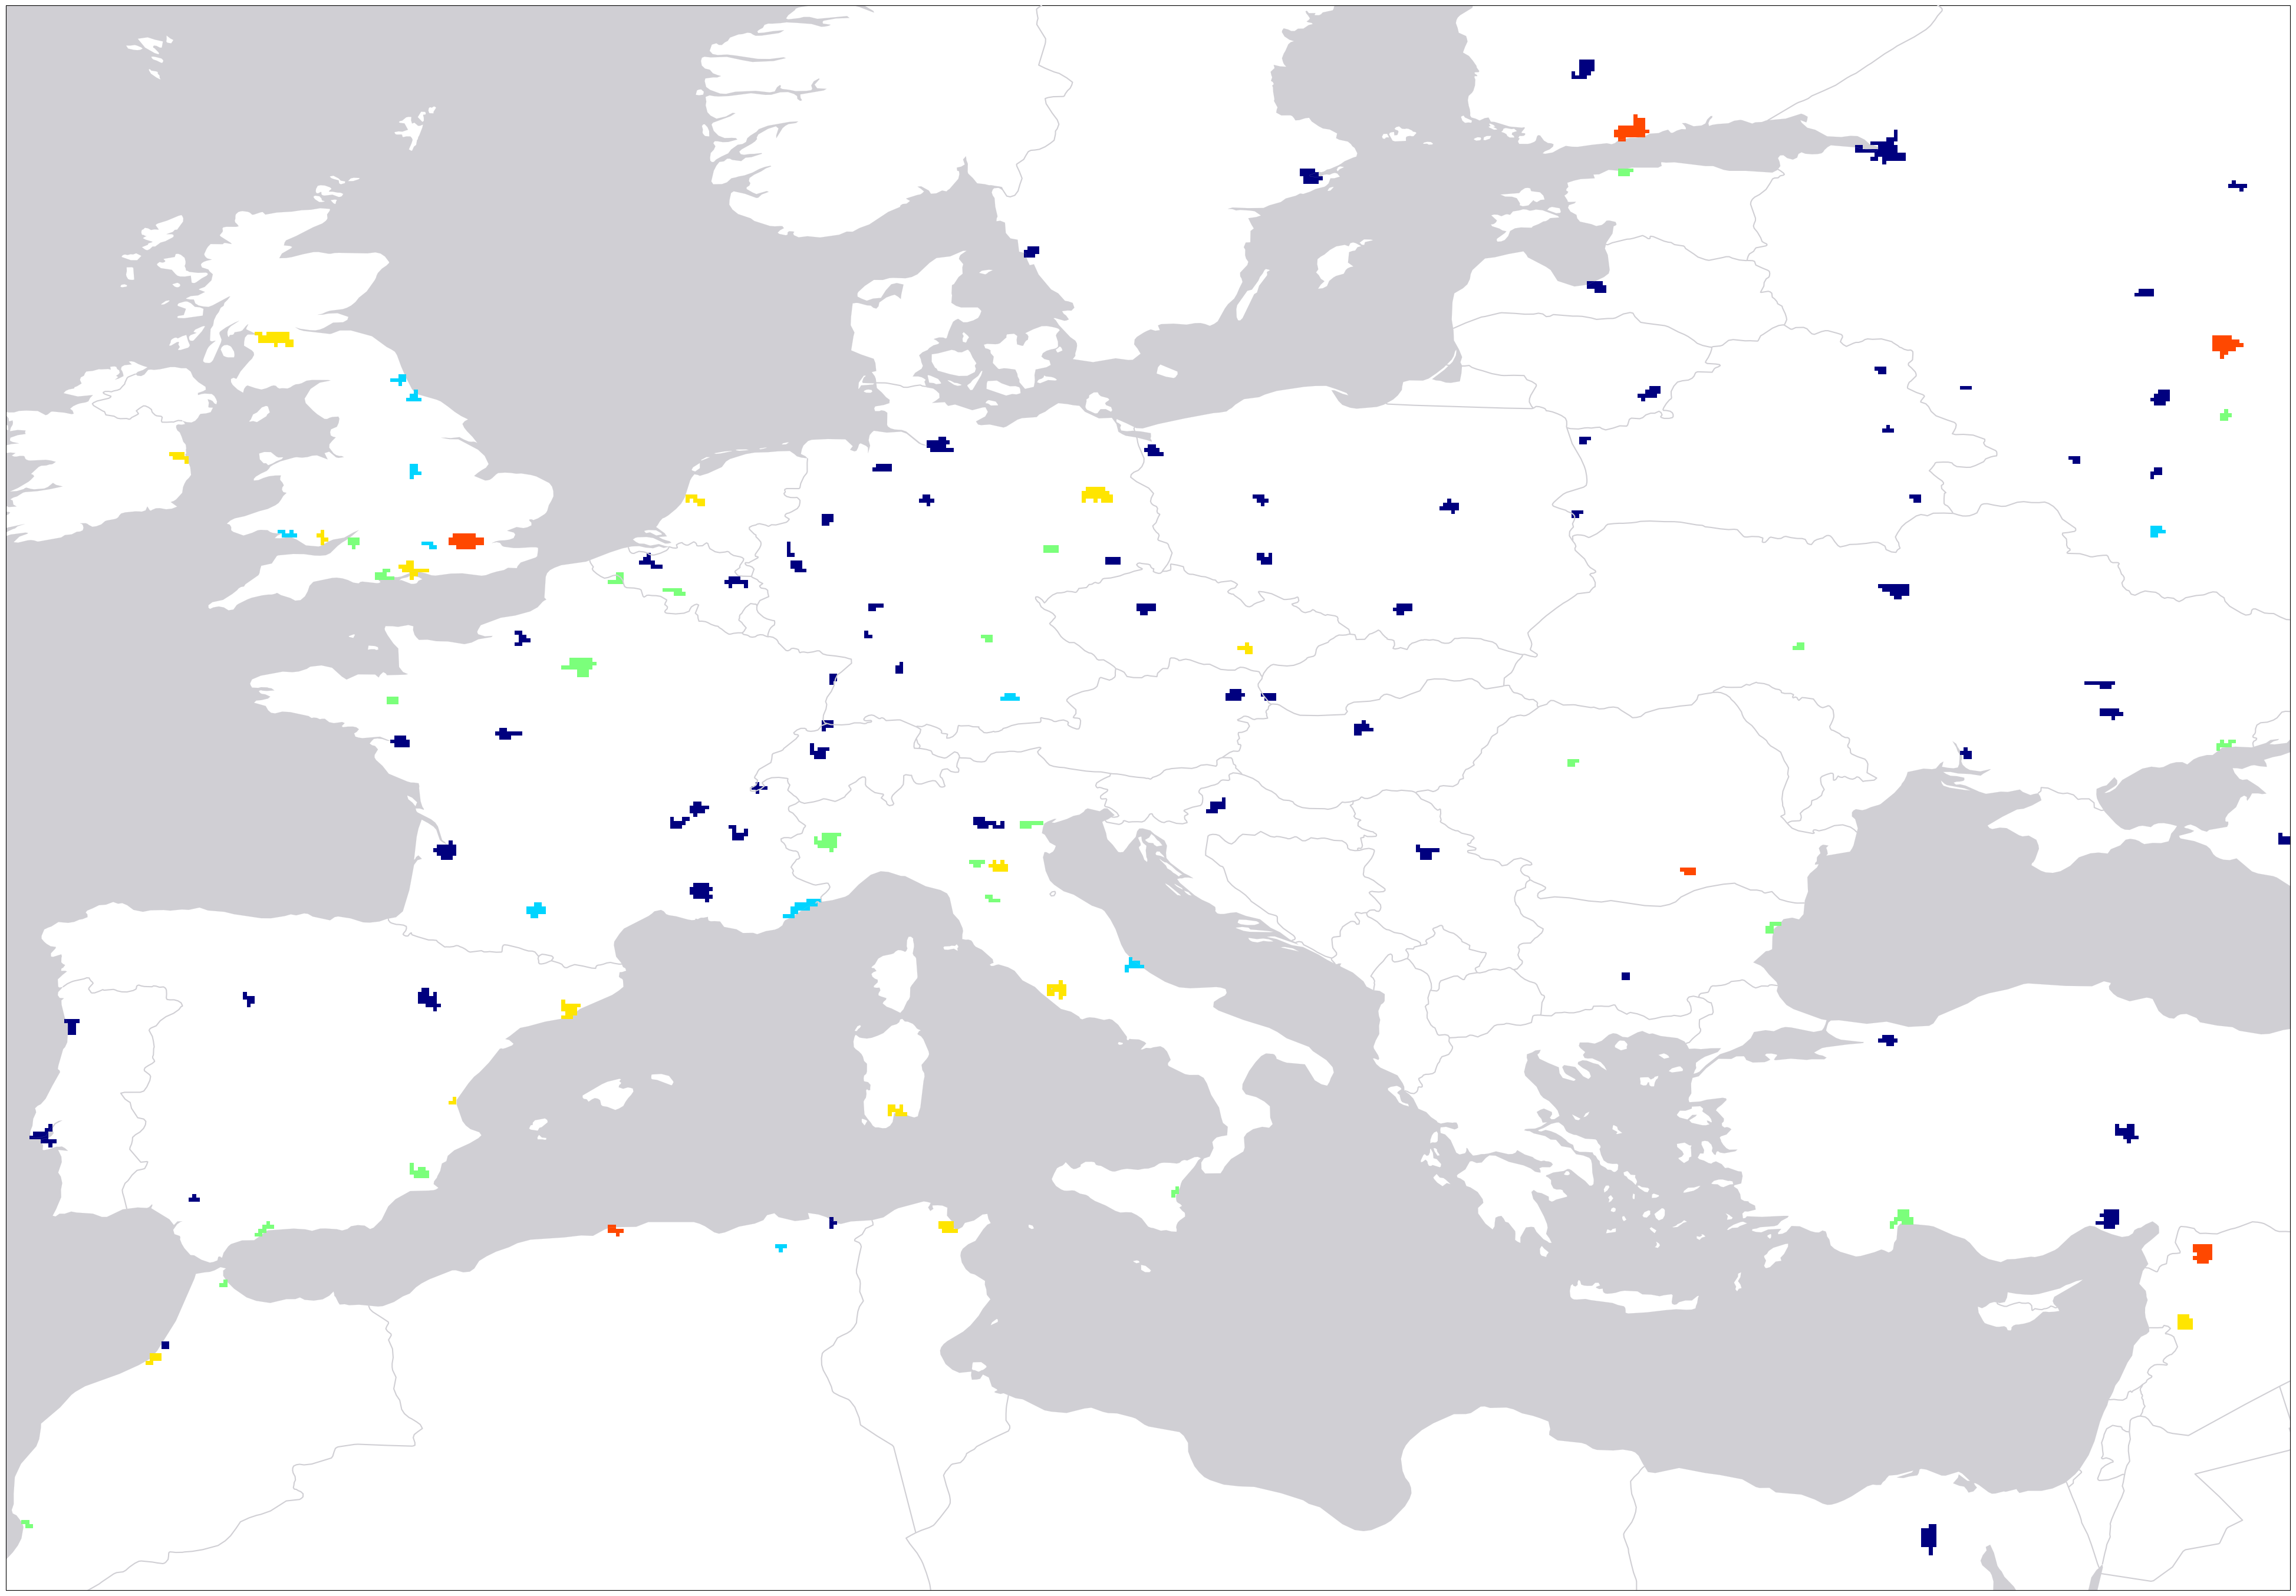

In [16]:
#---------------------------------------------------------------------------------------------------------------
#  population > 3,000,000 water availability < 300,000,000
#---------------------------------------------------------------------------------------------------------------
def draw_mask_sotowaku(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=3, subwidth=1, subline=False):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    zorder = 2: 白色の内枠が最前面(citymask)
    """
    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] > 3000*1e6 and mask_cropped[i, j] != 0:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
        ax.plot([x_index, x_index+delta], [y_index, y_index], color='white', transform=projection, linewidth=subwidth, zorder=2) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
        ax.plot([x_index, x_index+delta], [y_index, y_index], color='white', transform=projection, linewidth=subwidth, zorder=2) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
        ax.plot([x_index, x_index], [y_index, y_index+delta], color='white', transform=projection, linewidth=subwidth, zorder=2) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right
        ax.plot([x_index, x_index], [y_index, y_index+delta], color='white', transform=projection, linewidth=subwidth, zorder=2) # right

    return ax
    
upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(-10, 39, 29, 63)
availability_cropped = availability[upperindex:lowerindex, leftindex:rightindex]
population_cropped = population[upperindex:lowerindex, leftindex:rightindex]
region = citygrid_masked[upperindex:lowerindex, leftindex:rightindex]
region_masked = np.ma.masked_where(region==0, region)
region_pop = np.ma.masked_where(population_cropped < 3*1e6, region_masked)
region_ava = np.ma.masked_where(availability_cropped < 300*1e6, region_masked)

bounds = [0, 100, 300, 1000, 1700, 2500, 10000]

cmap = plt.get_cmap('jet_r', len(bounds))  # 10個の離散値
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.rcParams["font.size"] = 50
projection = ccrs.PlateCarree(central_longitude=0)
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(50,40), subplot_kw={'projection': projection})
imd = ax.imshow(region_ava, 
              cmap= cmap,
              norm = norm,
              extent=img_extent,
              transform=ccrs.PlateCarree(), 
             )
#ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea')
ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#ffffff')
ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#d0cfd4')
ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=5)
ax.gridlines(visible=False)
#cbar = fig.colorbar(imd, ax=ax, orientation='horizontal', pad=0.02)
#fig.suptitle('Available surface water in m3 per capita per year')
#draw_mask_sotowaku(img_extent, availability_cropped, ax=ax, sotowaku_color='grey', linewidth=3, subwidth=0.5)
plt.show()

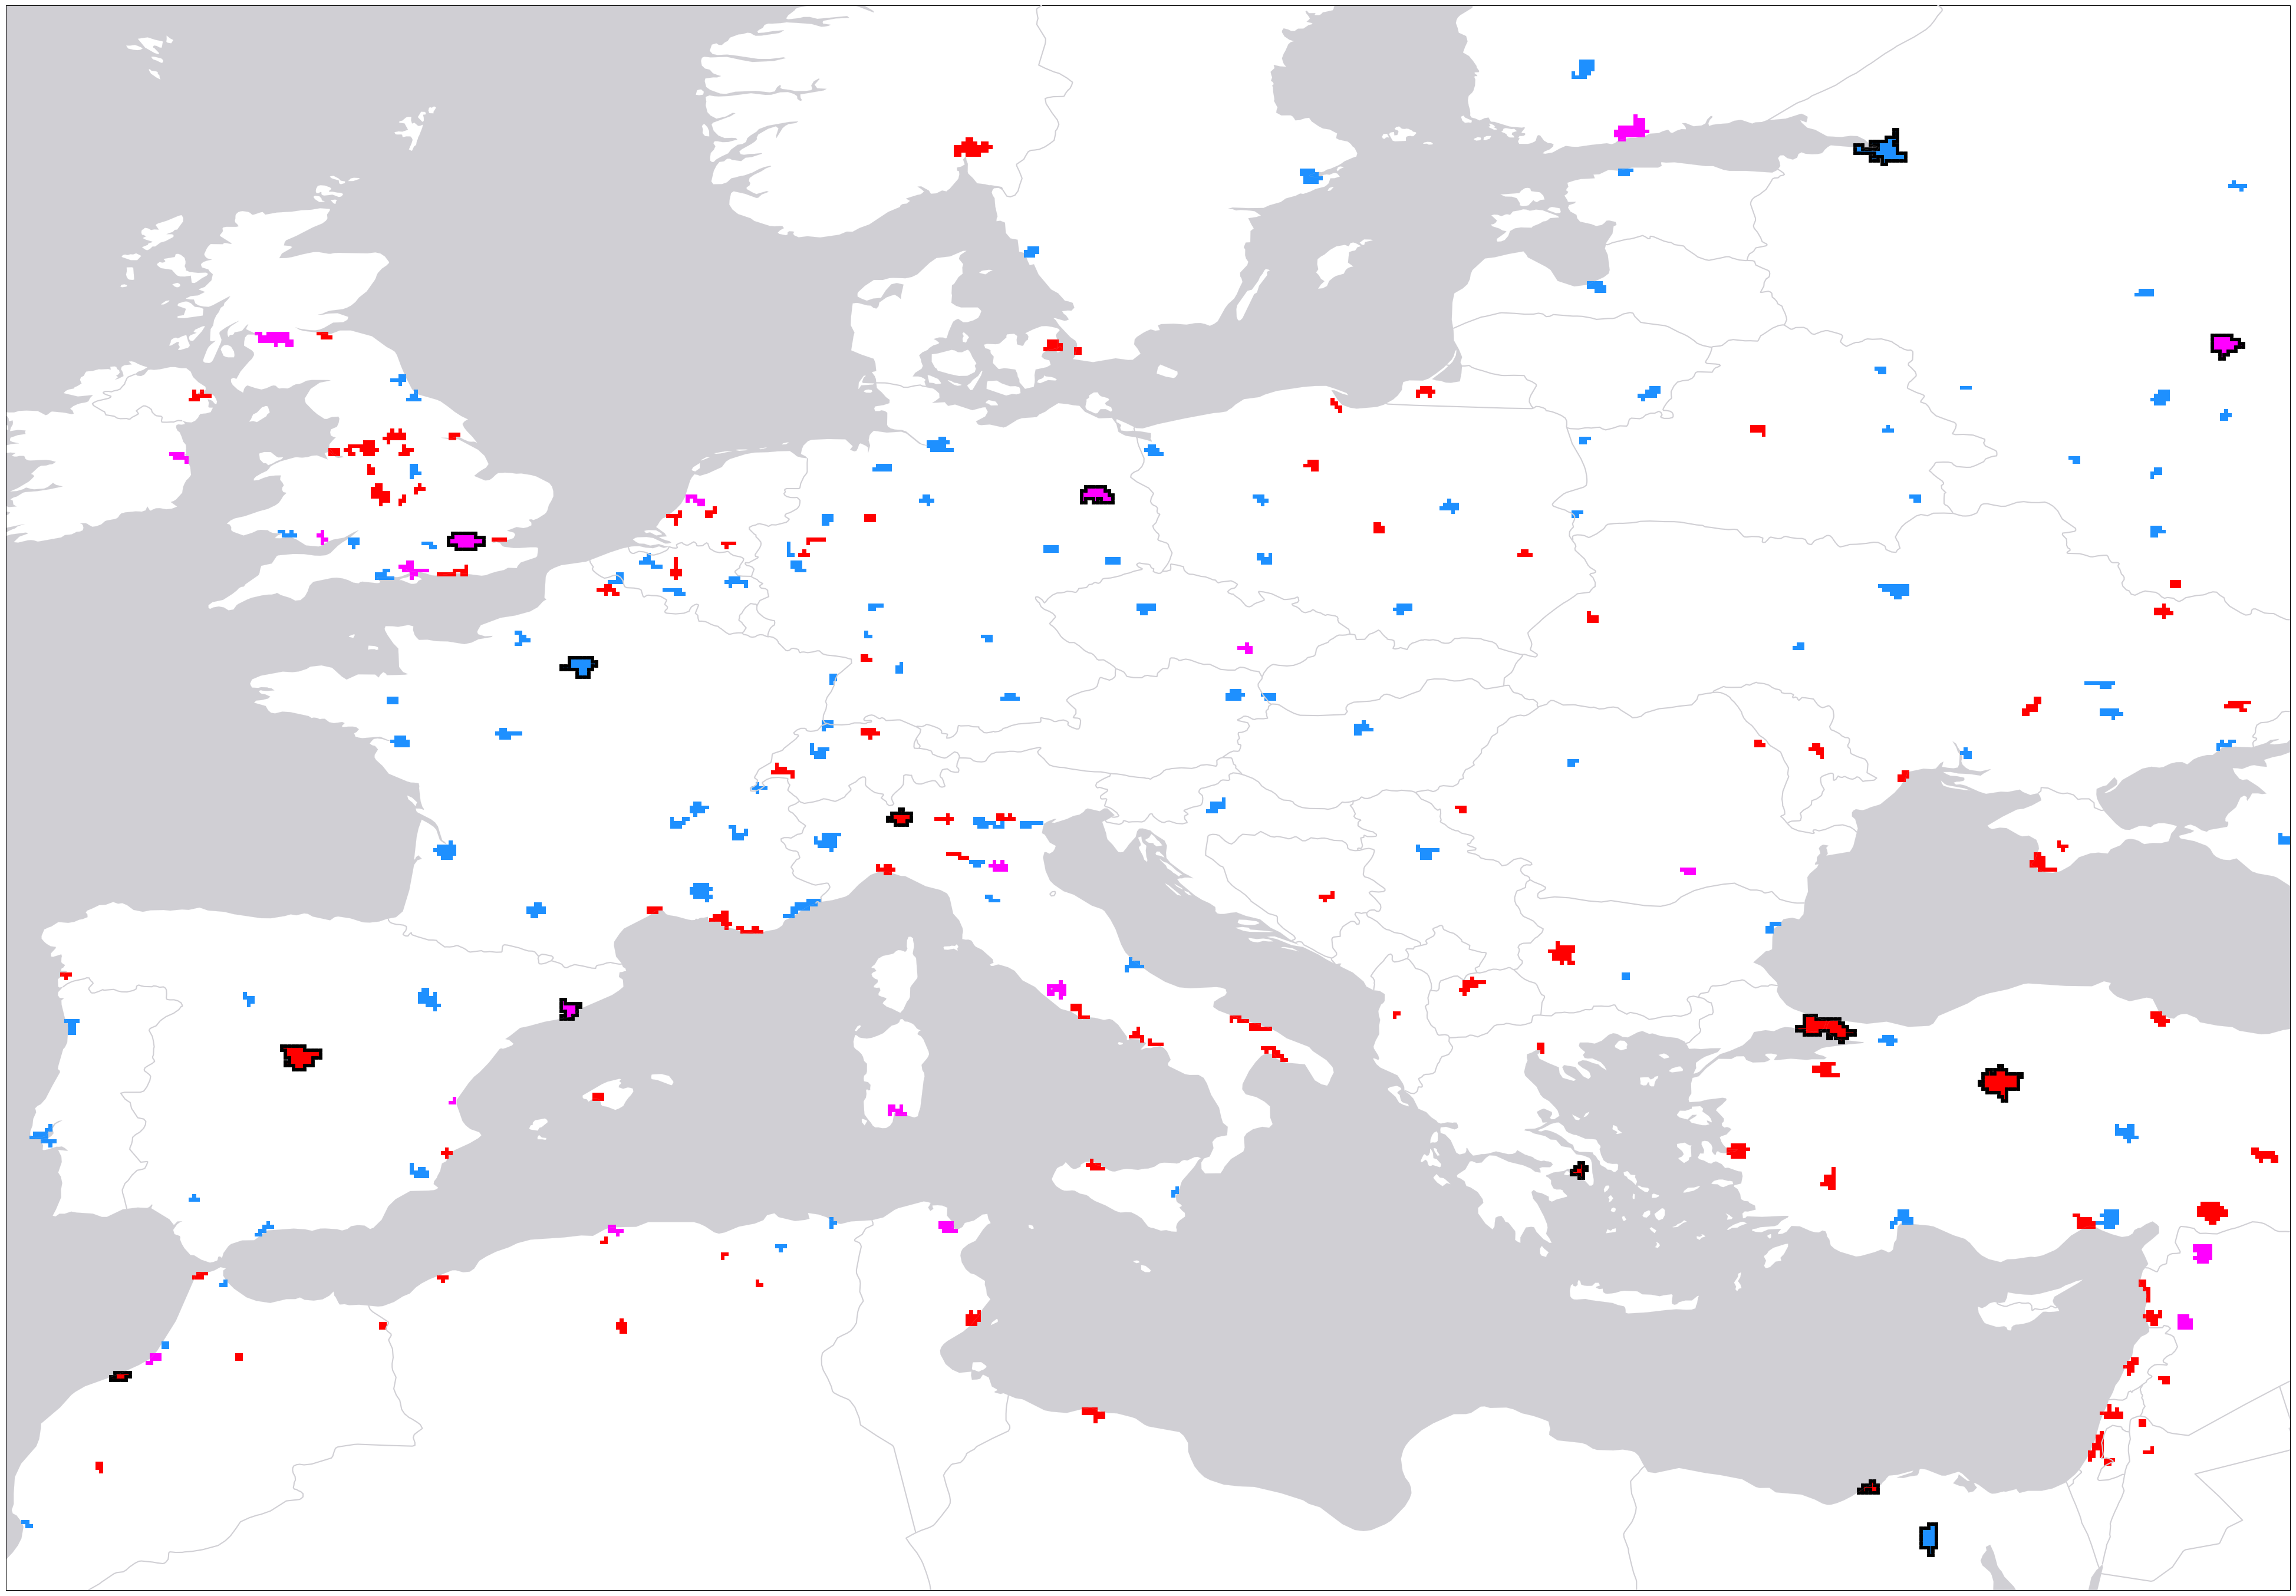

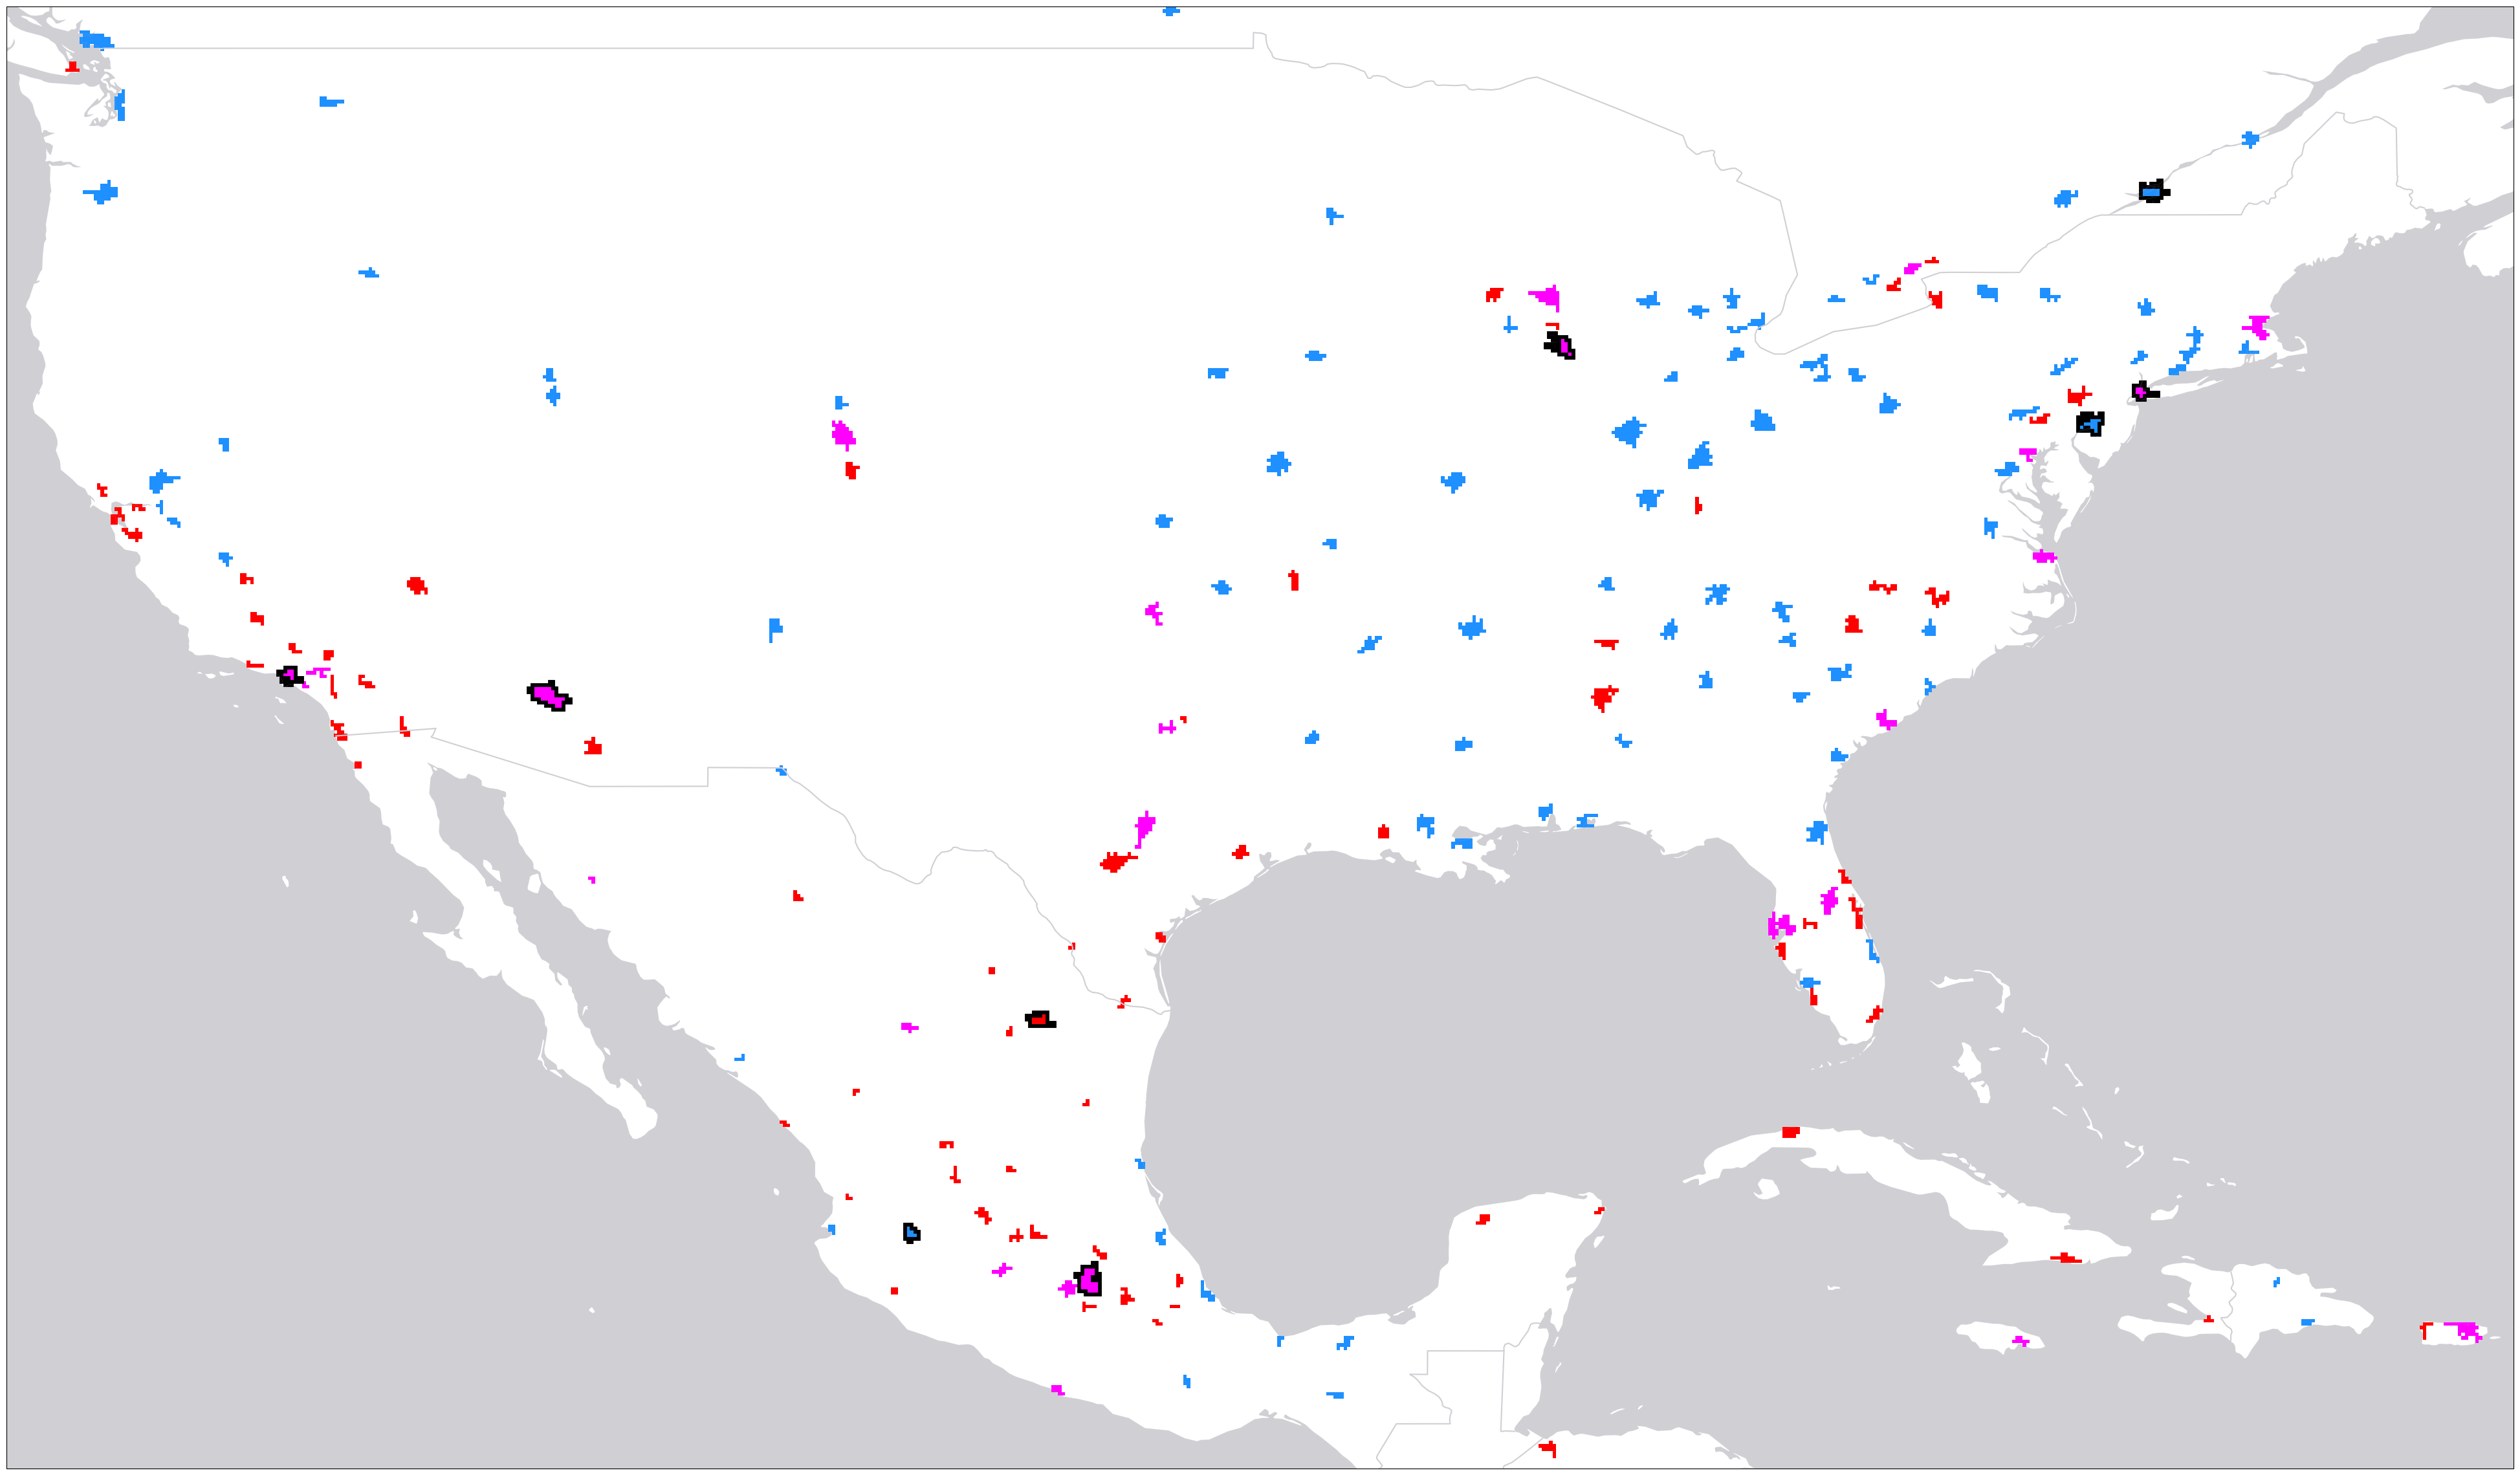

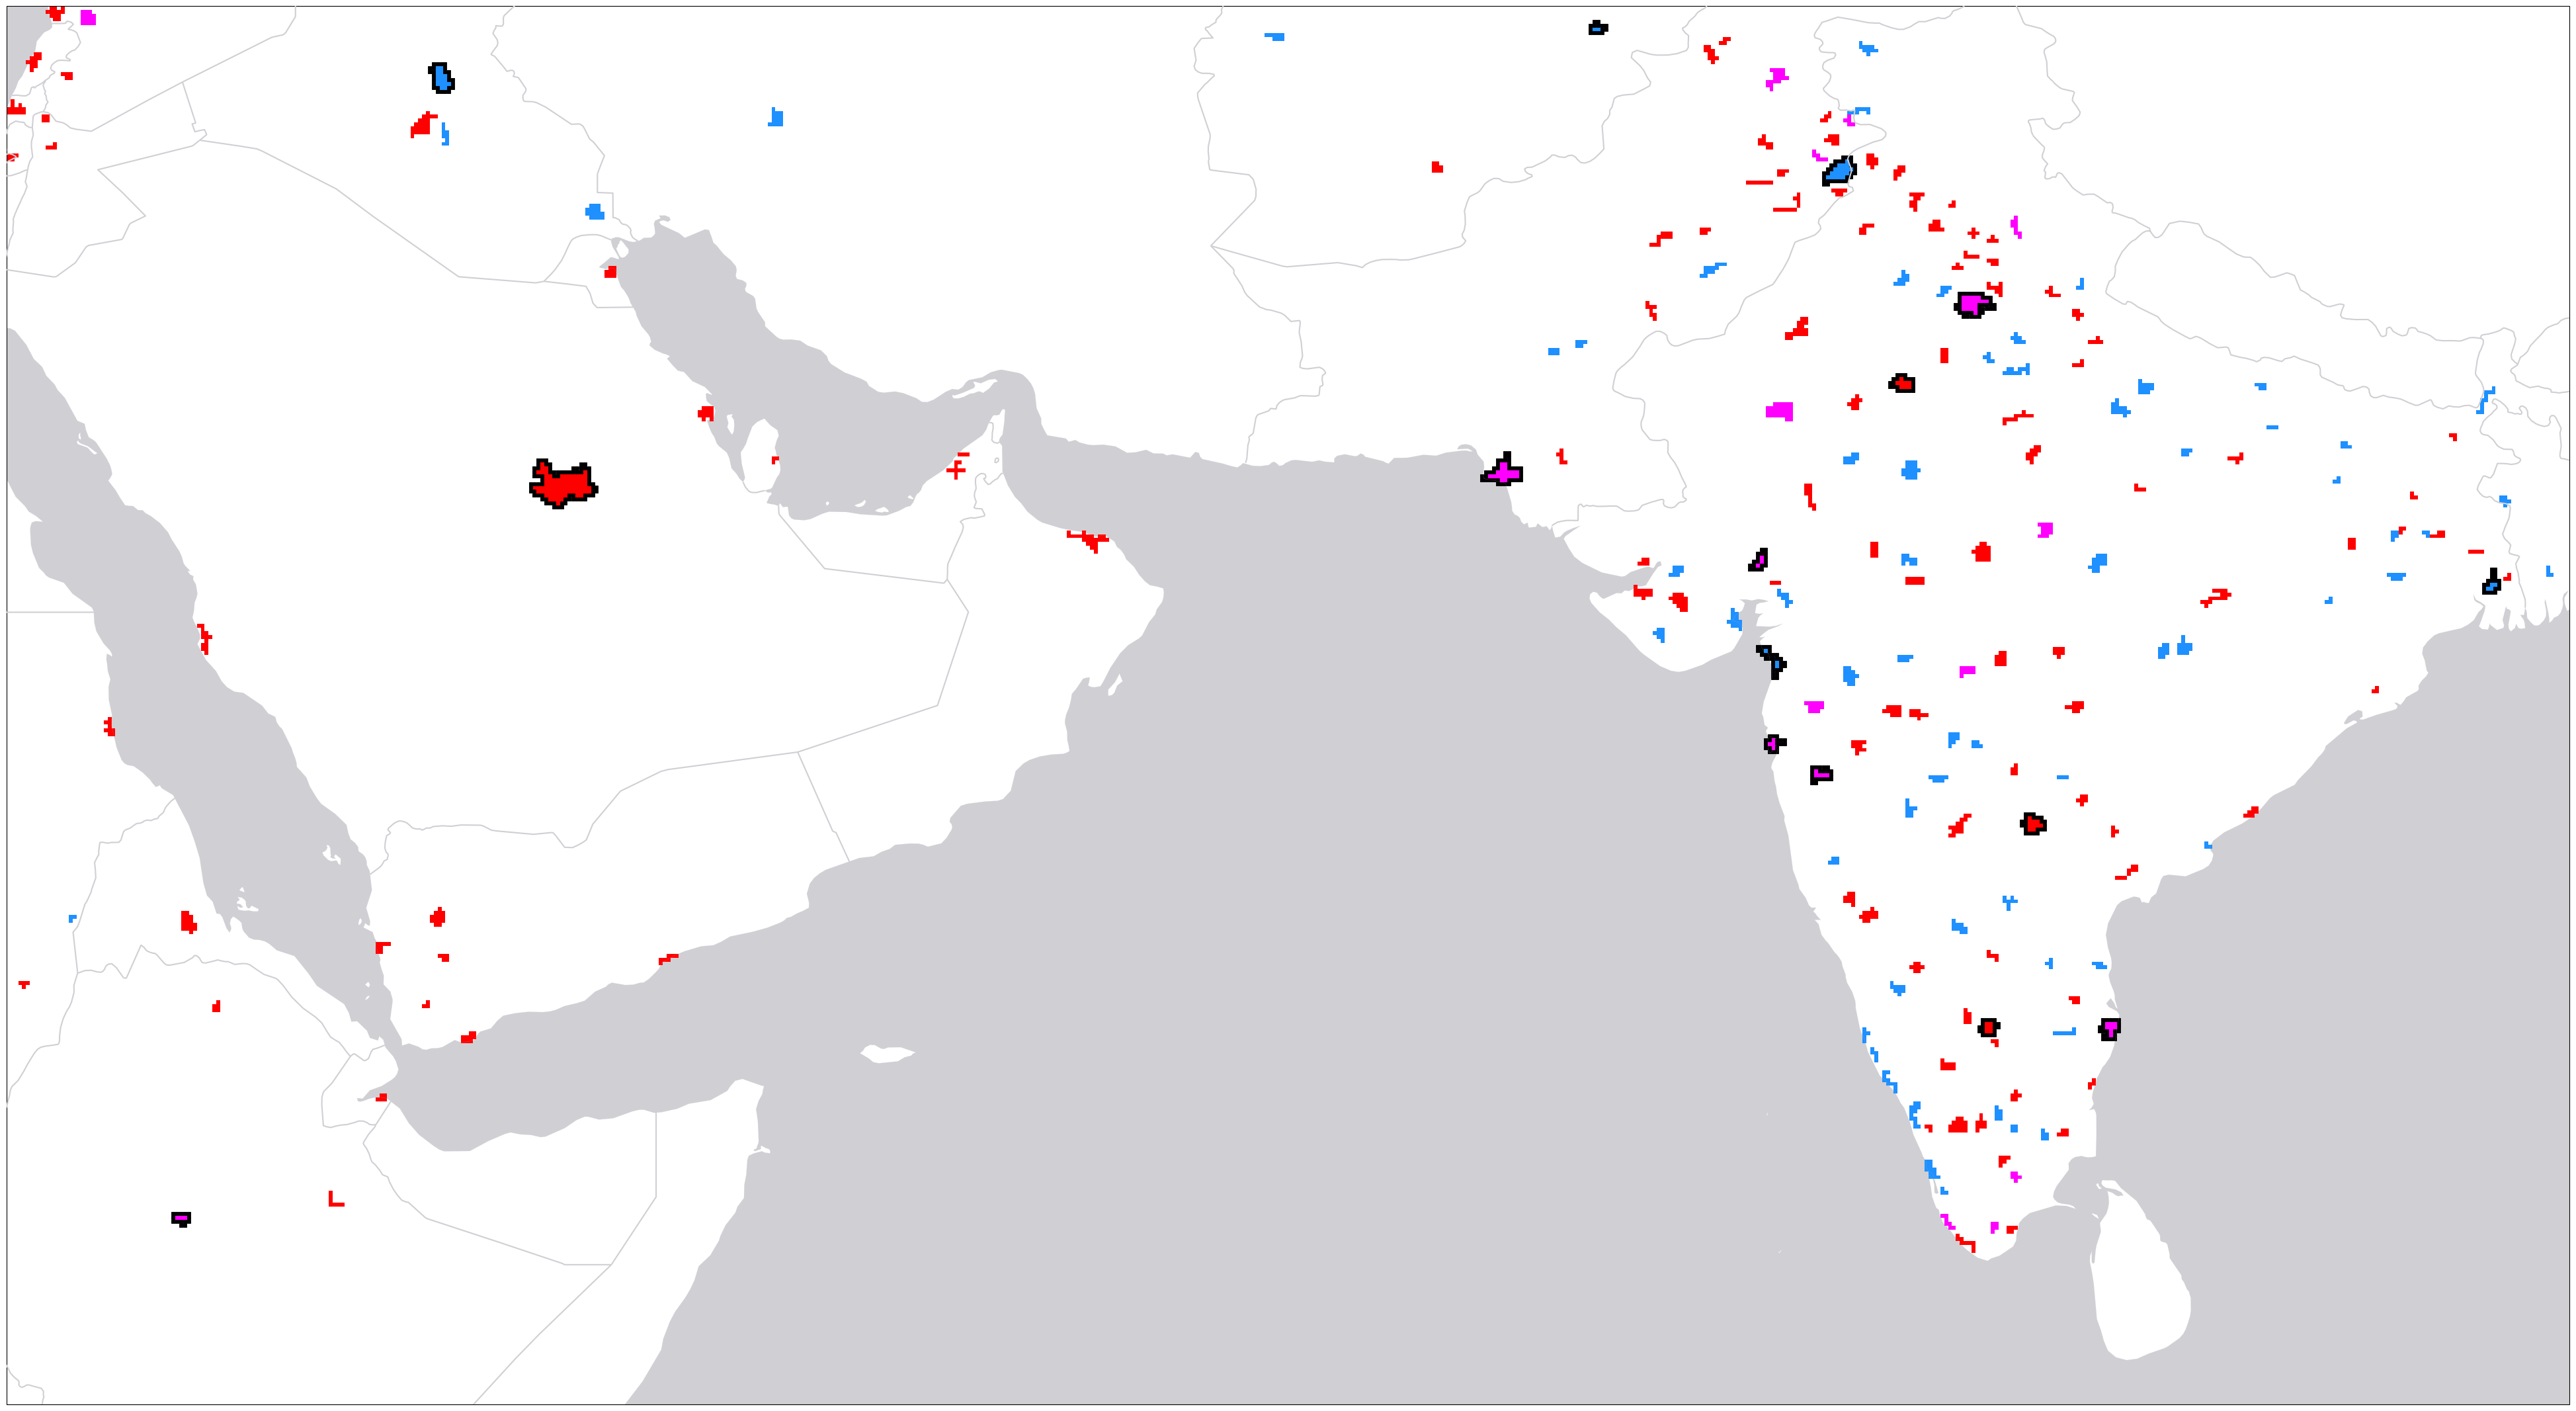

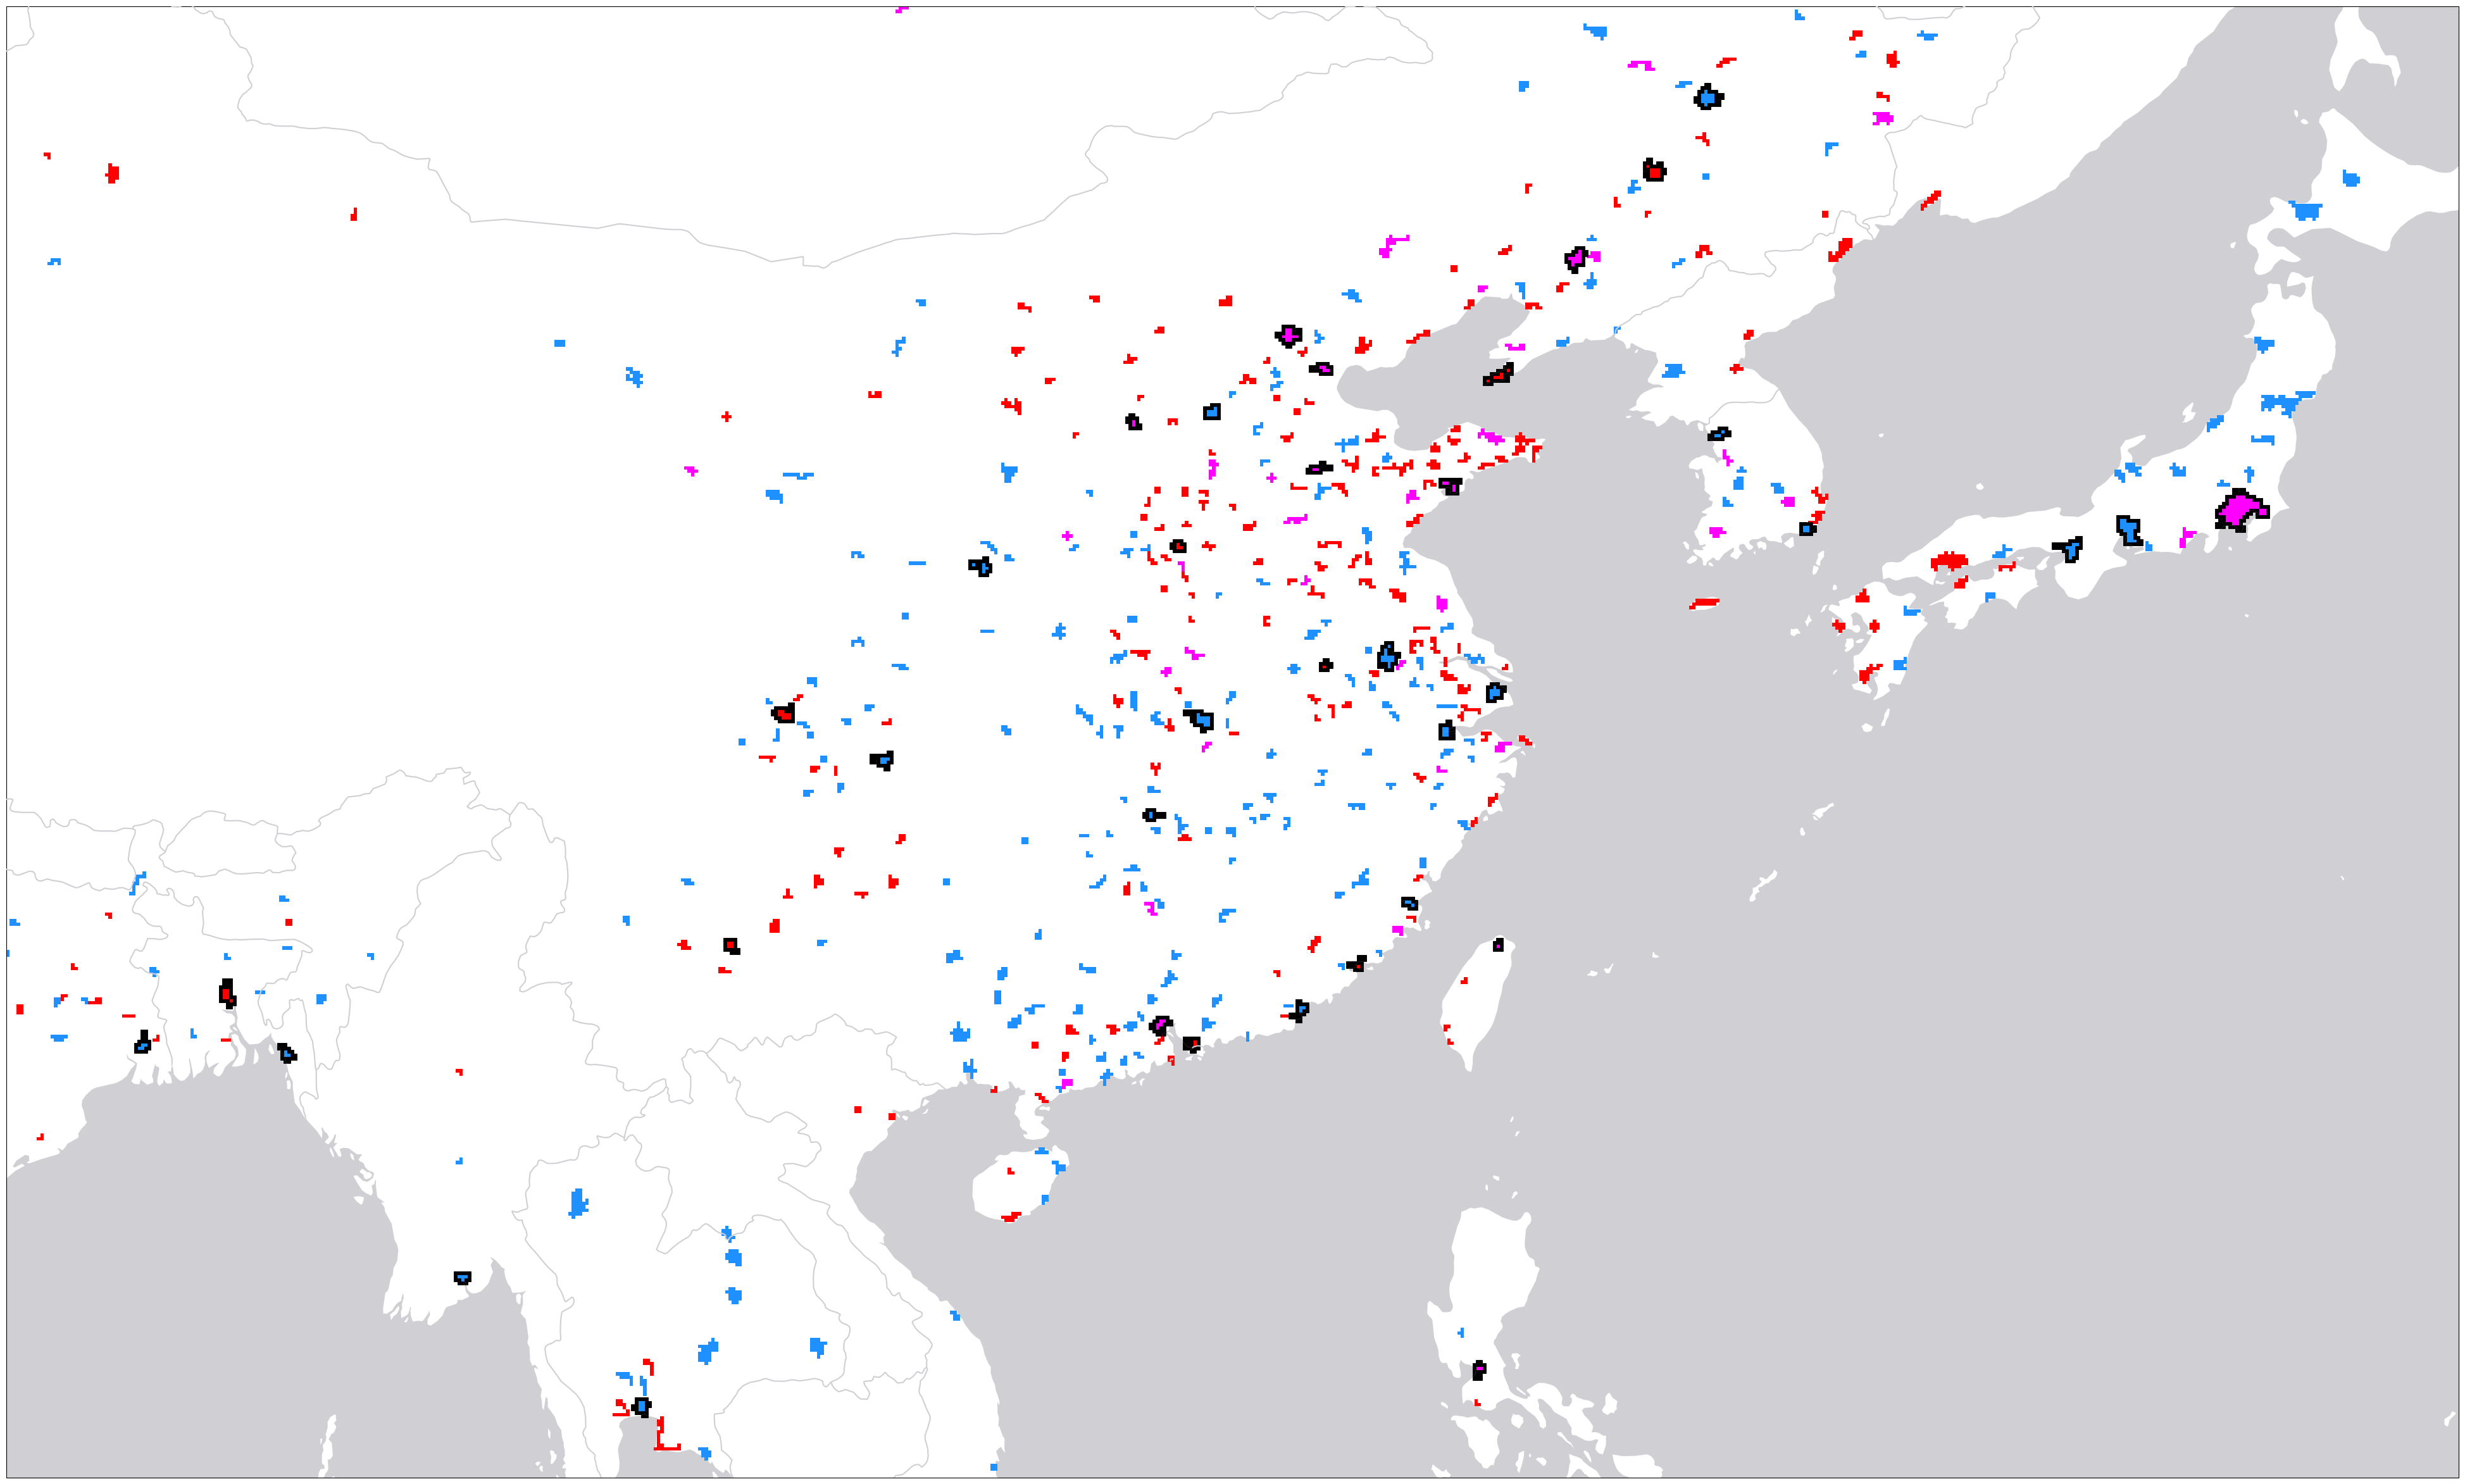

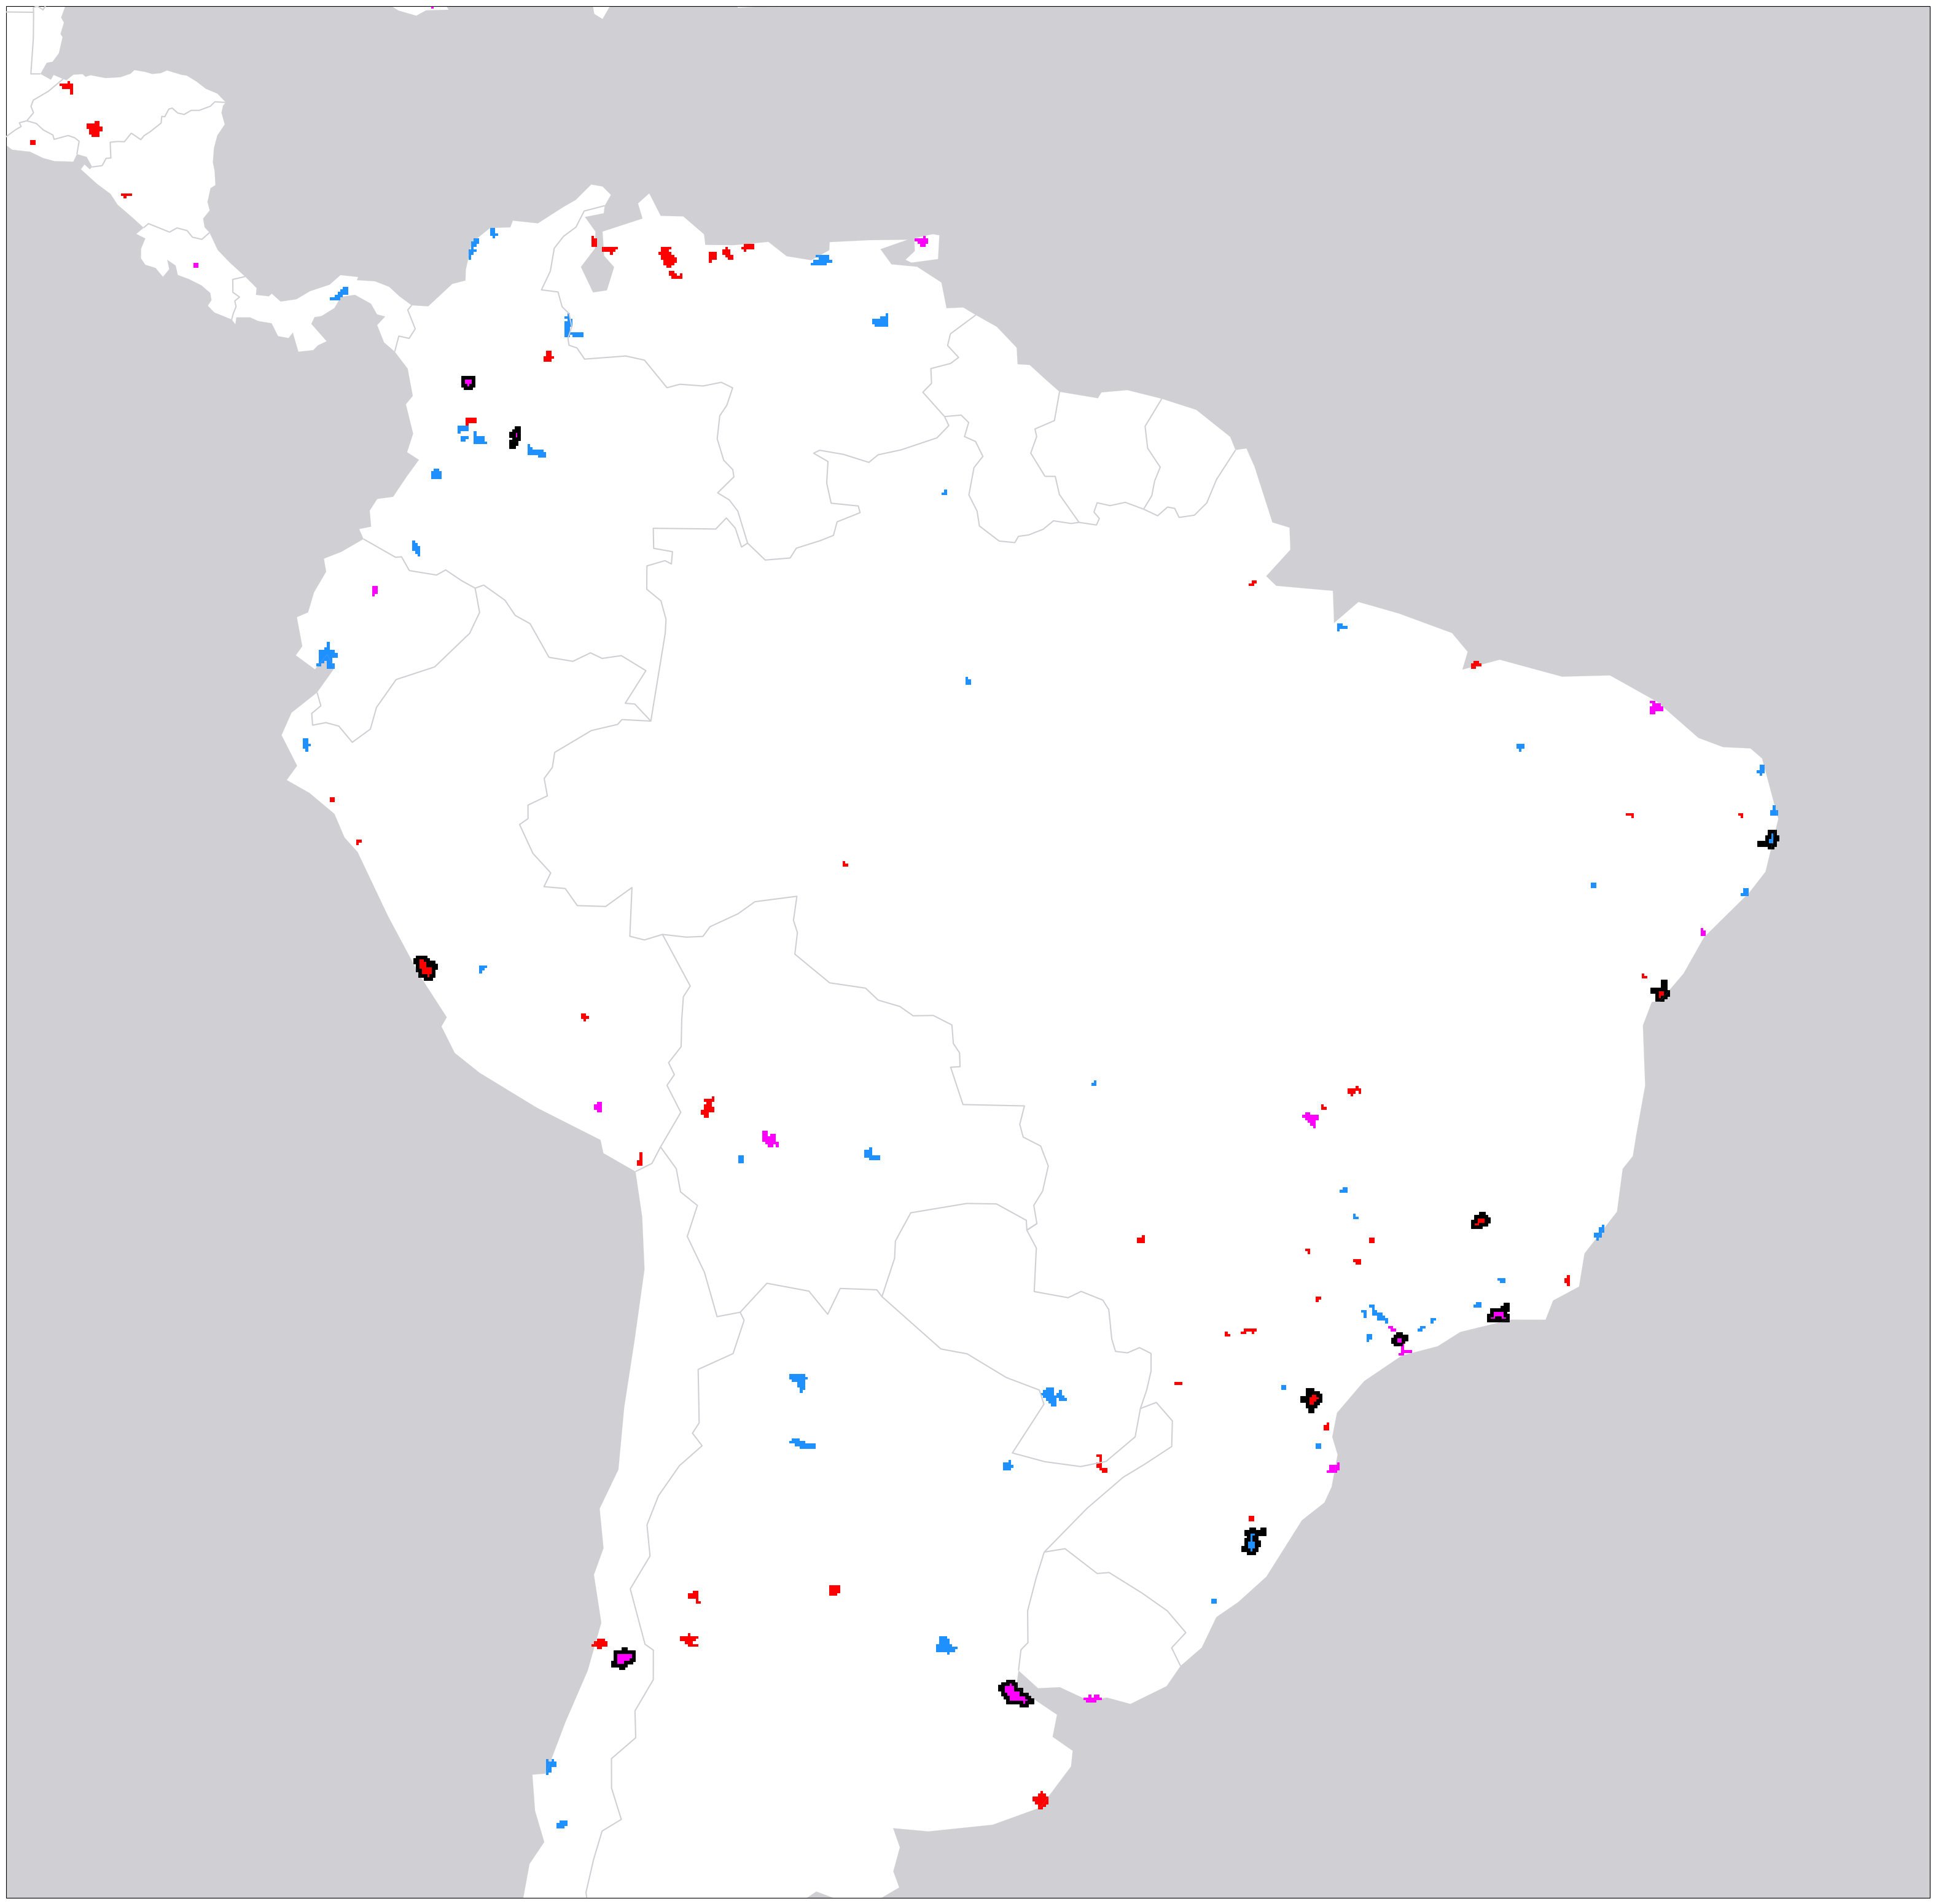

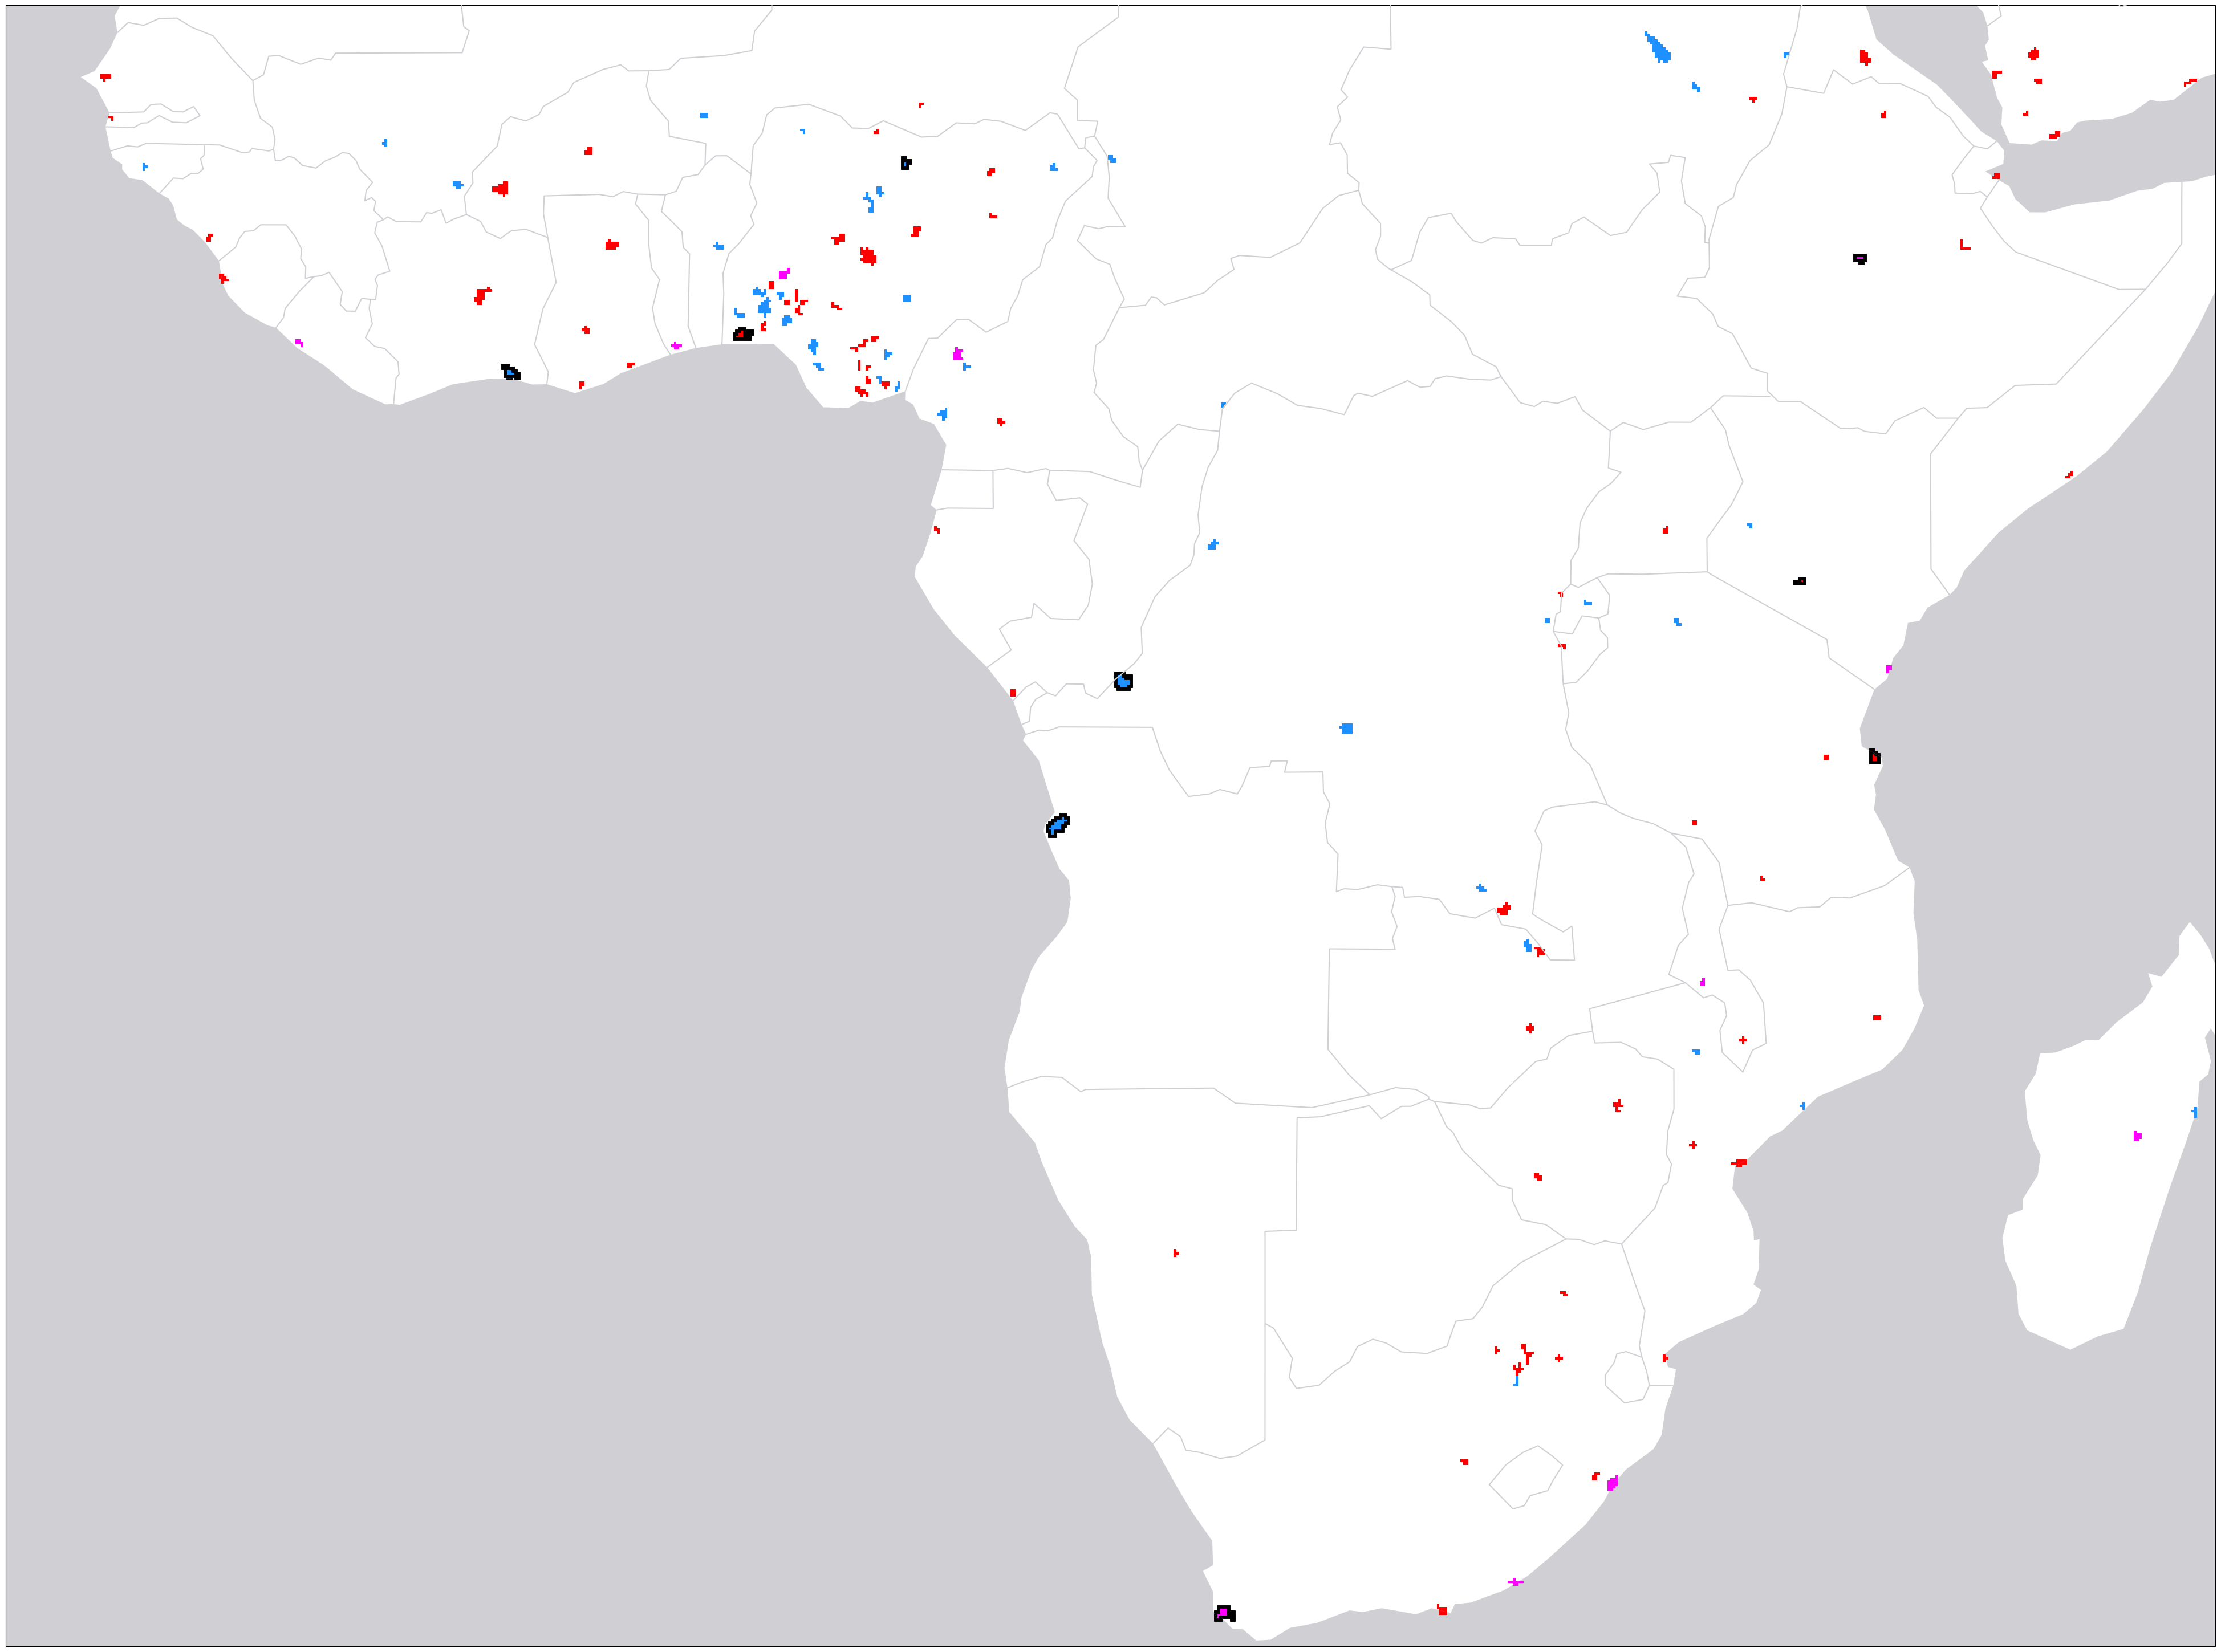

In [46]:
def draw_mask_sotowaku(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=3, subwidth=1, subline=False, threshold=3*1e6):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    zorder = 2: 白色の内枠が最前面(citymask)
    """
    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] > threshold and mask_cropped[i, j] != 0:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
        if subline is True:
            ax.plot([x_index, x_index+delta], [y_index, y_index], color='white', transform=projection, linewidth=subwidth, zorder=2) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
        if subline is True:
            ax.plot([x_index, x_index+delta], [y_index, y_index], color='white', transform=projection, linewidth=subwidth, zorder=2) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
        if subline is True:
            ax.plot([x_index, x_index], [y_index, y_index+delta], color='white', transform=projection, linewidth=subwidth, zorder=2) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right
        if subline is True:
            ax.plot([x_index, x_index], [y_index, y_index+delta], color='white', transform=projection, linewidth=subwidth, zorder=2) # right

    return ax

def region_plot(left, right, bottom, top, ava_threshold, pop_threshold):
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)
    
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    # wsi/pre/population_m3year.ipynb
    population_path = f'{h08dir}/wsi/dat/population/population_threshold_world.npy'
    population = np.load(population_path)
    population_cropped = population[upperindex:lowerindex, leftindex:rightindex]
    # wsi/pre/availability_m3year.ipynb
    availability_path = f'{h08dir}/wsi/dat/availablewater/availablewater_threshold_world.npy'
    availability = np.load(availability_path)
    availability_cropped = availability[upperindex:lowerindex, leftindex:rightindex]
    # wsi/pre/MPCY_citylonlat_citygrid.ipynb
    grid_path = f'{h08dir}/wsi/dat/cmy/world_citygrid.npy'
    citygrid = np.load(grid_path)
    citygrid_masked = np.ma.masked_where(citygrid==0, citygrid)
    
    region = citygrid_masked[upperindex:lowerindex, leftindex:rightindex]
    region_masked = np.ma.masked_where(region==0, region)
    availability_cropped = availability[upperindex:lowerindex, leftindex:rightindex]
    population_cropped = population[upperindex:lowerindex, leftindex:rightindex]
    region = citygrid_masked[upperindex:lowerindex, leftindex:rightindex]
    region_masked = np.ma.masked_where(region==0, region)
    
    # and = &, or = |
    # red: low availability and stressed 
    # purple: high availability and stressed
    # grey: not stressed
    red_mask = (availability_cropped > ava_threshold * 1e6) | (region_masked > 1000)
    purple_mask = (availability_cropped < ava_threshold * 1e6) | (region_masked > 1000)
    grey_mask = (region_masked < 1000)
    
    region_red = np.ma.masked_where(red_mask, region_masked)
    region_purple = np.ma.masked_where(purple_mask, region_masked)
    region_grey = np.ma.masked_where(grey_mask, region_masked)
    
    red_colormap = mcolors.ListedColormap(['red'])
    purple_colormap = mcolors.ListedColormap(['fuchsia'])
    grey_colormap = mcolors.ListedColormap(['dodgerblue'])
    
    plt.rcParams["font.size"] = 50
    projection = ccrs.PlateCarree(central_longitude=0)
    crs = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(50,40), subplot_kw={'projection': projection})
    imd = ax.imshow(region_red, 
                  cmap= red_colormap,
                  extent=img_extent,
                  transform=ccrs.PlateCarree(), 
                 )
    imd = ax.imshow(region_purple, 
                  cmap= purple_colormap,
                  extent=img_extent,
                  transform=ccrs.PlateCarree(), 
                 )
    imd = ax.imshow(region_grey, 
                  cmap= grey_colormap,
                  extent=img_extent,
                  transform=ccrs.PlateCarree(), 
                 )
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#d0cfd4')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=5)
    ax.gridlines(visible=False)
    draw_mask_sotowaku(img_extent, population_cropped, ax=ax, sotowaku_color='black', linewidth=4, subwidth=0.5, threshold=pop_threshold)
    #cbar = fig.colorbar(imd, ax=ax, orientation='horizontal', pad=0.02)
    #fig.suptitle('Available surface water in m3 per capita per year')
    plt.show()

value = 300 # 1000 * 1e6 means that million people gets 1000 m3/year, then 3000 * 1e6 means that 3 million people gets 1000 m3/year
value2 = 3*1e6 # 3million people or less
region_plot(-10, 39, 29, 63, ava_threshold=value, pop_threshold=value2)
region_plot(-125, -65, 15, 50, ava_threshold=value,pop_threshold=value2)
region_plot(35, 90, 5, 35,ava_threshold=value,pop_threshold=value2)
region_plot(85, 145, 12, 48,ava_threshold=value,pop_threshold=value2)
region_plot(-90, -30, -41, 18,ava_threshold=value,pop_threshold=value2)
region_plot(-20, 50, -35, 17,ava_threshold=value,pop_threshold=value2)